In [2]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------

import pandas as pd
import numpy as np
import os

from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold

import matplotlib.pyplot as plt
import seaborn as sns


# 1. Data cleaning and Exploratory data analysis

In [3]:
salaries = pd.read_csv("kaggle_salary.csv") 
#read data

C:\Users\Ween\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
salaries.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
0,0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,NaN
1,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0


### drop all the columns that have none or very little meaning in its values

In [5]:
#columns with name contains 'TEXT' which means its value is user input
salaries=salaries[salaries.columns.drop(list(salaries.filter(regex='TEXT')))]

#columns with name contains 'OTHER', same as 'TEXT'
salaries=salaries[salaries.columns.drop(list(salaries.filter(regex='OTHER')))]

#first two and last columns that do not contain any useful information
salaries=salaries[salaries.columns.drop(salaries.columns[[0,1,-1]])]


In [6]:
salaries.isnull().sum(axis=0)
#a lot of columns are full of nan values which contribute very little information

Q1                         0
Q2                         0
Q3                         0
Q4                         0
Q5                       135
Q6                         0
Q7                         0
Q8                        76
Q9                         0
Q10                      292
Q11_Part_1              7966
Q11_Part_2             11186
Q11_Part_3             11278
Q11_Part_4              9705
Q11_Part_5             11845
Q11_Part_6             12914
Q11_Part_7             14758
Q12_MULTIPLE_CHOICE     1572
Q13_Part_1              5177
Q13_Part_2              9066
Q13_Part_3             10238
Q13_Part_4             11755
Q13_Part_5             15325
Q13_Part_6             12525
Q13_Part_7             11535
Q13_Part_8             11839
Q13_Part_9              9747
Q13_Part_10            11002
Q13_Part_11            12199
Q13_Part_12            12908
                       ...  
Q47_Part_8              9588
Q47_Part_9             12632
Q47_Part_10            13030
Q47_Part_11   

### drop columns with more than 95% of values are nan, which means more than 95% of responds did not chooce this option and including it will not contribute much to training the model, so drop them

In [7]:
salaries.shape

(15430, 359)

In [8]:
salaries=salaries.dropna(thresh=len(salaries)*0.05, axis=1)

### we can drop rows with more than 92% of values are nan as well, reasoning is that there are 25 questions that have answers in one column, 12% of total number of columns. So 8% is a reasonable threshold. Further down it was discovered that a lot of nan were caused by not completing the survey.

In [9]:
salaries=salaries.dropna(thresh=len(salaries.columns)*0.08, axis=0)

In [10]:
salaries.shape
#nice size reduction

(13704, 210)

### just by looking at the data, Q7 and Q6 will help to fill each other's value, so cross reference Q6 and Q7 to have students' rows fixed 

In [11]:
salaries.loc[salaries['Q7']=='I am a student','Q6']='Student'
salaries.loc[salaries['Q6']=='Student','Q7']='I am a student'

# 2.Exploratory data analysis


# subset choosing
### let's choose a good subset of the dataset. First of all, the salary are all in USD but the living cost and earning varies a lot between countries. 
### And the responds from some countries have very small amount of count, and the responds need to be large enough so it's distribution can represent that country well. So take the top 10 most responded countries to exam.

In [12]:
salaries['Q3'].value_counts() #observation: a lot of countries have small amount of responds

United States of America                                3047
India                                                   2030
China                                                    736
Other                                                    612
Russia                                                   525
Brazil                                                   488
United Kingdom of Great Britain and Northern Ireland     455
Germany                                                  447
Canada                                                   393
France                                                   375
Japan                                                    369
Spain                                                    322
Italy                                                    225
Australia                                                208
Poland                                                   193
Netherlands                                              182
Turkey                  

In [13]:
salaries_country=salaries.groupby('Q3').filter(lambda x : len(x)>400).reset_index(drop=True) 
#drop any country that has less than 400 responds

salaries_country=salaries_country[salaries_country.Q3 !='Other'] #drop the 'other' rows
salaries_country['Q3'].value_counts()

United States of America                                3047
India                                                   2030
China                                                    736
Russia                                                   525
Brazil                                                   488
United Kingdom of Great Britain and Northern Ireland     455
Germany                                                  447
Name: Q3, dtype: int64

C:\Users\Ween\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


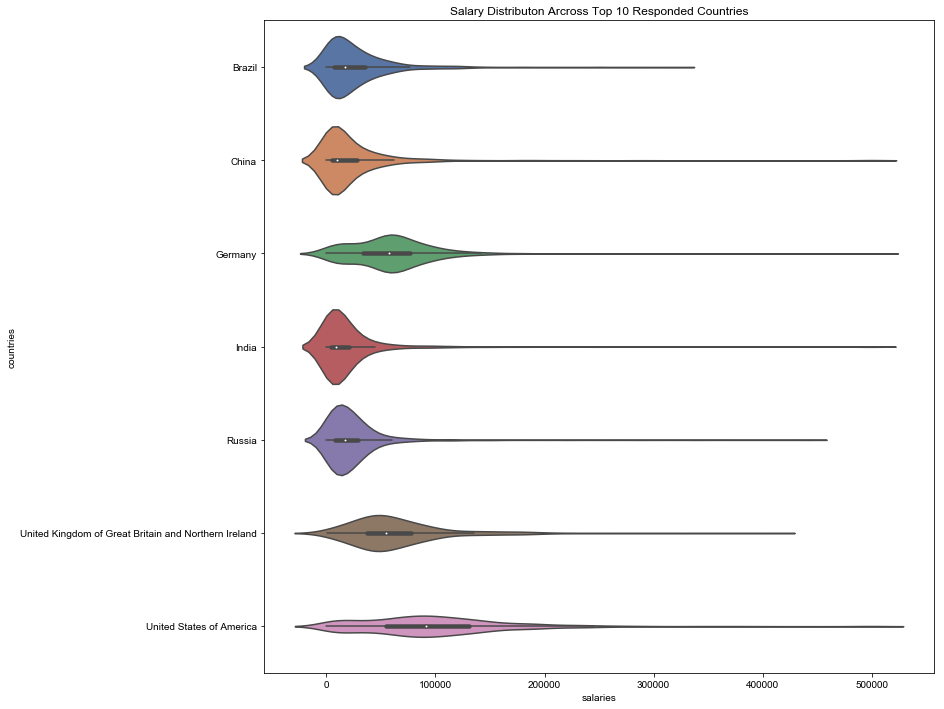

In [14]:
import seaborn as sns

#import data
data=pd.DataFrame()
data['countries']=salaries_country['Q3'].copy().astype('category')
data['salaries']=salaries_country['Q9'].copy().astype('int')

#plot
plt.figure(figsize=(12,12))
plt.title('Salary Distributon Arcross Top 10 Responded Countries')
sns.set(font_scale=1.3) #set font scale so it is more readable
sns.set(rc={'figure.figsize':(12,8)})
sns.violinplot(x="salaries", y="countries", data=data)



### as it shown above, the average for the top 10 responded countries clearly divided into 3 groups: tier 1 is USA, tier 2 contains Canada, France, Germany, UK and Japan, tier 3 contains Brazil, China, India and Russia. 
### 1 interesting observation is that with over 2300 responds, India has relatively very small variance.
### considering the responds from the rest of the countries are less than 400 and could potentially have outliers that have much higher effect on the model, we will use the subset of top 10 responded countries to build our model.
### next, let's get a feel of the other category's effect on the earning potential. Since I return to shcool after a few years of working to earn a master degree and switch from manufacturing to some other industry with greater earning potential, let's look into these factors.

In [15]:
data['education']=salaries_country['Q4'].copy().astype('category')
data['industry']=salaries_country['Q7'].copy().astype('category')
data['occupation']=salaries_country['Q6'].copy().astype('category')

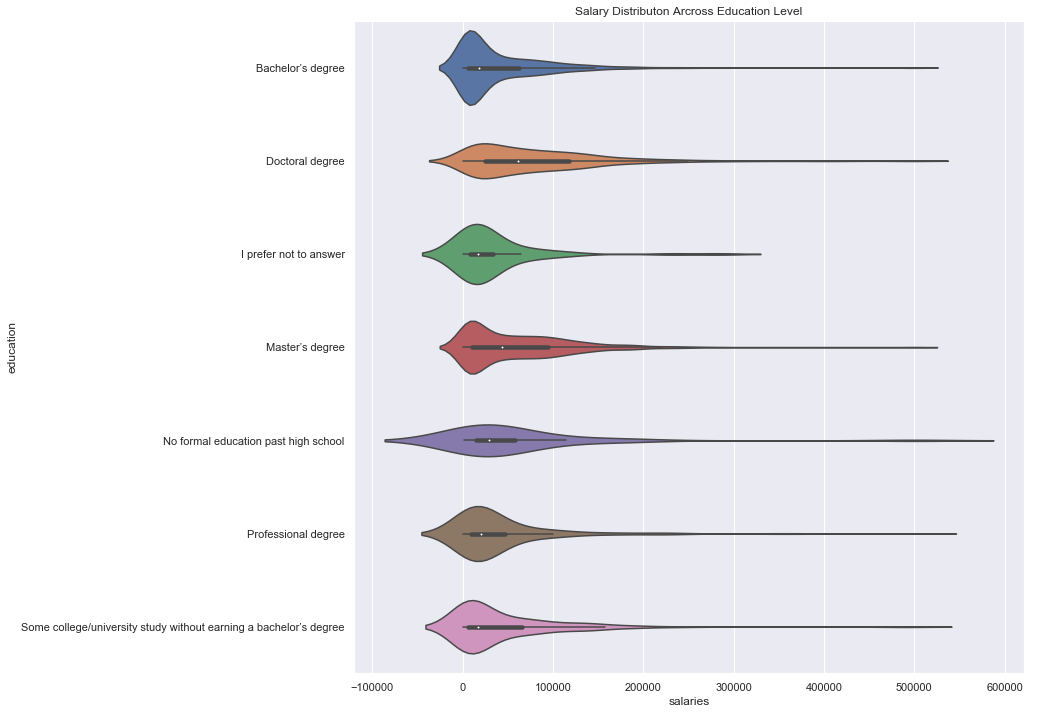

In [16]:
plt.figure(figsize=(12,12))
plt.title('Salary Distributon Arcross Education Level')
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.3) #set font scale so it is more readable
sns.violinplot(x="salaries", y="education", data=data)

### as expeceted, master's degree has second highest salary mean. But there are a lot of people at the lower end. I guess it is might be a lot of student take co-op or research to earn some money.

In [17]:
salaries_country['Q9']=salaries_country['Q9'].astype('int') #set salary as a int column
salaries_country[(salaries_country['Q4']=="Master’s degree") & (salaries_country['Q9']<2000)].tail(30)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_7
7005,Male,22-24,United States of America,Master’s degree,"Medical or life sciences (biology, chemistry, ...",Student,I am a student,0-1,1059,I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7091,Male,30-34,Brazil,Master’s degree,Engineering (non-computer focused),Data Analyst,Marketing/CRM,0-1,476,We are exploring ML methods (and may one day p...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7125,Male,22-24,China,Master’s degree,Engineering (non-computer focused),Student,I am a student,5-10,470,I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7279,Male,25-29,United States of America,Master’s degree,Other,Student,I am a student,0-1,1949,I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7309,Male,25-29,India,Master’s degree,"Computer science (software engineering, etc.)",Student,I am a student,0-1,909,We use ML methods for generating insights (but...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7332,Male,22-24,India,Master’s degree,"Computer science (software engineering, etc.)",Data Engineer,Other,0-1,729,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7351,Female,18-21,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Student,I am a student,10-15,257,I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7538,Male,22-24,United Kingdom of Great Britain and Northern I...,Master’s degree,Mathematics or statistics,Student,I am a student,10-15,322,I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7557,Male,30-34,India,Master’s degree,Mathematics or statistics,Data Scientist,Computers/Technology,1-2,643,We are exploring ML methods (and may one day p...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7570,Male,22-24,India,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,Computers/Technology,2-3,777,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### so most of these low income holding master's degree are from India and China, amd majority of them self-identify as student or research assistant. But most of the research assistant earning that little most likely are students as well. So let's fill them with student status.

In [18]:
salaries_country.loc[(salaries_country['Q4']=="Master’s degree") & (salaries_country['Q9']<2000) & (salaries_country['Q6']=='Research Assistant'),'Q7']='I am a student'
salaries_country.loc[(salaries_country['Q4']=="Master’s degree") & (salaries_country['Q9']<2000) & (salaries_country['Q6']=='Research Assistant'),'Q6']='Student'

### check out those who's not student 

In [19]:
salaries_country[(salaries_country['Q4']=="Master’s degree") & (salaries_country['Q9']<2000) & (salaries_country['Q6']!='Student')]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_7
59,Female,22-24,China,Master’s degree,Engineering (non-computer focused),Data Engineer,Computers/Technology,0-1,553,We are exploring ML methods (and may one day p...,...,NaN,NaN,NaN,Include a text file describing all dependencies,NaN,NaN,Requires too much technical knowledge,NaN,NaN,NaN
68,Male,25-29,China,Master’s degree,"Computer science (software engineering, etc.)",Data Analyst,Computers/Technology,1-2,1187,No (we do not use ML methods),...,Make sure the code is human-readable,NaN,NaN,NaN,NaN,Too time-consuming,Requires too much technical knowledge,Afraid that others will use my work without gi...,NaN,NaN
133,Male,30-34,India,Master’s degree,Engineering (non-computer focused),Data Engineer,Computers/Technology,3-4,1684,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,Too time-consuming,NaN,Afraid that others will use my work without gi...,NaN,NaN
135,Female,22-24,China,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,Computers/Technology,0-1,595,We are exploring ML methods (and may one day p...,...,NaN,NaN,Define relative rather than absolute file paths,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN
169,Male,25-29,India,Master’s degree,Mathematics or statistics,Data Scientist,Energy/Mining,4-5,1838,"We have well established ML methods (i.e., mod...",...,Make sure the code is human-readable,Define all random seeds,Define relative rather than absolute file paths,Include a text file describing all dependencies,NaN,NaN,NaN,Afraid that others will use my work without gi...,NaN,NaN
194,Male,40-44,India,Master’s degree,Environmental science or geology,Data Analyst,Non-profit/Service,1-2,419,We are exploring ML methods (and may one day p...,...,Make sure the code is human-readable,NaN,NaN,NaN,Too expensive,Too time-consuming,Requires too much technical knowledge,NaN,NaN,NaN
271,Male,22-24,India,Master’s degree,"Computer science (software engineering, etc.)",Data Analyst,Accounting/Finance,0-1,1576,We are exploring ML methods (and may one day p...,...,Make sure the code is human-readable,NaN,NaN,Include a text file describing all dependencies,Too expensive,Too time-consuming,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN
293,Male,25-29,India,Master’s degree,Engineering (non-computer focused),Business Analyst,Other,0-1,225,We use ML methods for generating insights (but...,...,Make sure the code is human-readable,Define all random seeds,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN
321,Female,22-24,India,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,Manufacturing/Fabrication,0-1,466,We are exploring ML methods (and may one day p...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
342,Male,50-54,India,Master’s degree,Other,Consultant,Computers/Technology,5-10,74,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 87 rows of them, these data are clearly not very useful and should be dropped

In [20]:
salaries_country.shape

(7728, 210)

In [21]:
salaries_country=salaries_country.drop(salaries_country[(salaries_country['Q4']=="Master’s degree") & (salaries_country['Q9']<2000) & (salaries_country['Q6']!='Student') & (salaries_country['Q6']!='Research Assistant')].index)
salaries_country.reset_index(drop=True,inplace=True)
salaries_country.shape

(7647, 210)

## Now check out distribution across industries

Text(0.5, 1.0, 'Salary Distribution Across Industries')

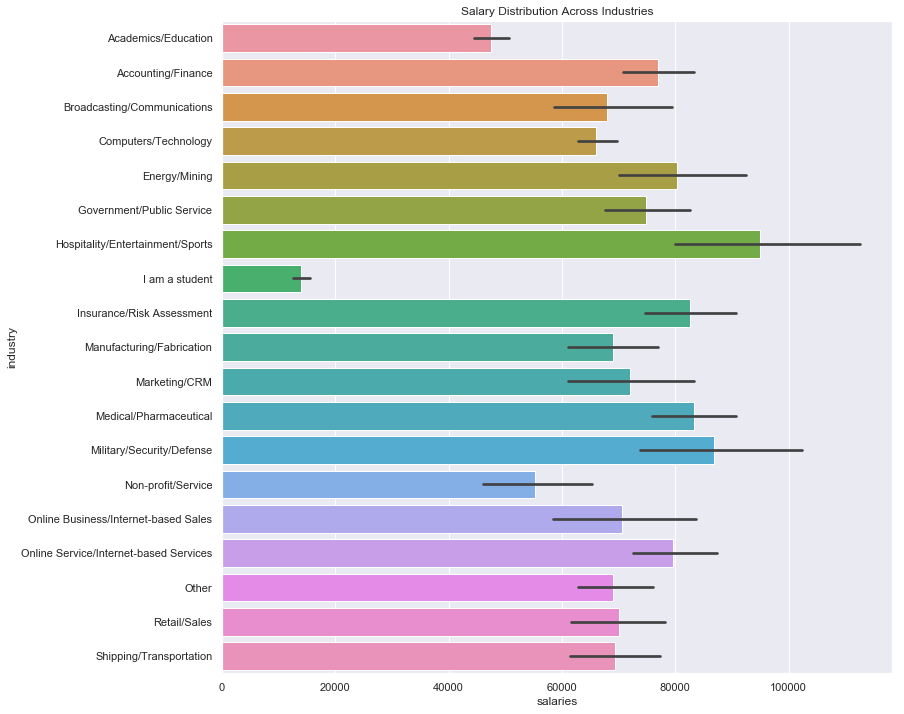

In [22]:
plt.figure(figsize=(12,12))
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x="salaries", y="industry", data=data)
plt.title('Salary Distribution Across Industries')

### Hospitality/Entertainment/Sports earn big bucks! One more industry to consider for me after graduation. Accounting /Finance is not as high as I expected. Military/Security/Defense, Energy/Mining Online Business/Internet-based Sales and Medical/Pharmaceutical are all before it.

# Clean data as looking into each questions

### first, extract columns with answers in single column

In [23]:
salaries_single=salaries_country[salaries_country.columns.drop(list(salaries_country.filter(regex='Part')))]
#any column with name contains 'Part' are not single column answer

In [24]:
single_columns=salaries[salaries.columns.drop(list(salaries.filter(regex='Part')))].iloc[0] 
#get the list of answers in single column
single_columns

Q1                                What is your gender? - Selected Choice
Q2                                           What is your age (# years)?
Q3                             In which country do you currently reside?
Q4                     What is the highest level of formal education ...
Q5                     Which best describes your undergraduate major?...
Q6                     Select the title most similar to your current ...
Q7                     In what industry is your current employer/cont...
Q8                     How many years of experience do you have in yo...
Q9                     What is your current yearly compensation (appr...
Q10                    Does your current employer incorporate machine...
Q12_MULTIPLE_CHOICE    What is the primary tool that you use at work ...
Q17                    What specific programming language do you use ...
Q18                    What programming language would you recommend ...
Q20                    Of the choices that you sele

In [25]:
salaries_single.isnull().sum() 

Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                       36
Q6                        0
Q7                        0
Q8                       37
Q9                        0
Q10                       0
Q12_MULTIPLE_CHOICE       0
Q17                    1394
Q18                      61
Q20                    2259
Q22                    2469
Q23                     139
Q24                     148
Q25                     162
Q26                     168
Q32                    1913
Q37                    3587
Q40                    1195
Q43                    2124
Q46                    2081
Q48                    2086
dtype: int64

### Q1, Q2, Q3, Q4, Q6, Q7, Q8, Q9, Q10, Q12 have no nan values and Q5, Q8, Q18, Q23, Q24, Q25, Q26 are with some sort of nan values, the rest got a lot of nans.
### let's start clean data and look into those missing values
# Q5 Which best describes your undergraduate major?

In [26]:
salaries_single['Q5'].value_counts()

Computer science (software engineering, etc.)                    2768
Engineering (non-computer focused)                               1362
Mathematics or statistics                                         982
A business discipline (accounting, economics, finance, etc.)      617
Physics or astronomy                                              426
Medical or life sciences (biology, chemistry, medicine, etc.)     338
Information technology, networking, or system administration      312
Other                                                             276
Social sciences (anthropology, psychology, sociology, etc.)       244
Humanities (history, literature, philosophy, etc.)                137
Environmental science or geology                                   85
Fine arts or performing arts                                       37
I never declared a major                                           27
Name: Q5, dtype: int64

In [27]:
salaries_single[(salaries_single['Q5'].isnull())].head() 

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q23,Q24,Q25,Q26,Q32,Q37,Q40,Q43,Q46,Q48
118,Male,25-29,China,No formal education past high school,NaN,Software Engineer,Accounting/Finance,5-10,30550,"We recently started using ML methods (i.e., mo...",...,50% to 74% of my time,5-10 years,1-2 years,Probably not,Categorical Data,NaN,Independent projects are equally important as ...,0-10,0,"Yes, most ML models are ""black boxes"""
434,Male,35-39,United Kingdom of Great Britain and Northern I...,No formal education past high school,NaN,Other,Insurance/Risk Assessment,3-4,153986,We are exploring ML methods (and may one day p...,...,25% to 49% of my time,1-2 years,1-2 years,Definitely not,Numerical Data,NaN,No opinion; I do not know,0,90-100,I am confident that I can understand and expla...
1187,Male,35-39,Russia,No formal education past high school,NaN,Data Scientist,Accounting/Finance,0-1,3084,No (we do not use ML methods),...,1% to 25% of my time,1-2 years,1-2 years,Maybe,Time Series Data,Coursera,No opinion; I do not know,NaN,20-30,I am confident that I can understand and expla...
1538,Female,18-21,Brazil,No formal education past high school,NaN,Student,I am a student,0-1,7553,I do not know,...,1% to 25% of my time,< 1 year,< 1 year,Probably not,Categorical Data,NaN,No opinion; I do not know,NaN,NaN,NaN
2217,Male,18-21,Russia,No formal education past high school,NaN,Student,I am a student,3-4,7970,"We have well established ML methods (i.e., mod...",...,50% to 74% of my time,< 1 year,< 1 year,Maybe,Image Data,NaN,No opinion; I do not know,NaN,NaN,NaN


### as it shown above, most of the missing value correlate to the 'No formal education past high school' in Q4 so, let's fill it with no_undergrad

In [28]:
salaries_single['Q5'].fillna(value='no_undergrad',inplace=True)

C:\Users\Ween\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [29]:
salaries_single['Q5'].isnull().sum() #checked

0

# Q8 How many years of experience do you have in your position?

In [30]:
salaries_single[(salaries_single['Q8'].isnull())].head(20) 

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q23,Q24,Q25,Q26,Q32,Q37,Q40,Q43,Q46,Q48
184,Male,18-21,India,Master’s degree,Engineering (non-computer focused),Student,I am a student,NaN,2629,I do not know,...,1% to 25% of my time,< 1 year,< 1 year,Definitely yes,Numerical Data,NaN,Independent projects are much more important t...,10-20,30-40,"I view ML models as ""black boxes"" but I am con..."
298,Male,18-21,India,Bachelor’s degree,"Computer science (software engineering, etc.)",Student,I am a student,NaN,9190,I do not know,...,25% to 49% of my time,< 1 year,< 1 year,Probably not,Tabular Data,Other,Independent projects are slightly more importa...,10-20,20-30,I am confident that I can understand and expla...
504,Male,22-24,India,Master’s degree,"Computer science (software engineering, etc.)",Student,I am a student,NaN,2361,No (we do not use ML methods),...,50% to 74% of my time,< 1 year,I have never studied machine learning but plan...,Probably not,Numerical Data,Coursera,Independent projects are slightly more importa...,0,0-10,I am confident that I can understand and expla...
571,Female,22-24,United Kingdom of Great Britain and Northern I...,Doctoral degree,"Medical or life sciences (biology, chemistry, ...",Student,I am a student,NaN,16657,We use ML methods for generating insights (but...,...,75% to 99% of my time,3-5 years,1-2 years,Maybe,Geospatial Data,Coursera,Independent projects are slightly more importa...,20-30,40-50,I am confident that I can understand and expla...
622,Female,18-21,India,Bachelor’s degree,"Medical or life sciences (biology, chemistry, ...",Student,I am a student,NaN,6818,I do not know,...,0% of my time,< 1 year,< 1 year,Probably not,NaN,NaN,Independent projects are much more important t...,0-10,0,I am confident that I can understand and expla...
658,Male,18-21,India,Some college/university study without earning ...,"Computer science (software engineering, etc.)",Student,I am a student,NaN,2630,I do not know,...,25% to 49% of my time,1-2 years,< 1 year,Probably not,Text Data,Coursera,Independent projects are much more important t...,0-10,0-10,"I view ML models as ""black boxes"" but I am con..."
660,Male,50-54,India,Doctoral degree,Engineering (non-computer focused),Data Scientist,Academics/Education,NaN,29302,No (we do not use ML methods),...,1% to 25% of my time,10-20 years,5-10 years,Definitely yes,Numerical Data,Udemy,Independent projects are slightly more importa...,0-10,0-10,I am confident that I can explain the outputs ...
812,Male,22-24,India,Bachelor’s degree,"Computer science (software engineering, etc.)",Student,I am a student,NaN,58,We are exploring ML methods (and may one day p...,...,50% to 74% of my time,< 1 year,1-2 years,Maybe,Video Data,Coursera,Independent projects are slightly more importa...,40-50,30-40,"I view ML models as ""black boxes"" but I am con..."
873,Female,25-29,United States of America,Doctoral degree,Mathematics or statistics,Student,I am a student,NaN,15886,"We recently started using ML methods (i.e., mo...",...,75% to 99% of my time,1-2 years,1-2 years,Maybe,NaN,Coursera,Independent projects are slightly less importa...,0,50-60,"I view ML models as ""black boxes"" but I am con..."
999,Male,18-21,United States of America,Bachelor’s degree,"A business discipline (accounting, economics, ...",Student,I am a student,NaN,4460,No (we do not use ML methods),...,0% of my time,I have never written code but I want to learn,I have never studied machine learning but plan...,Probably not,NaN,NaN,Independent projects are equally important as ...,NaN,NaN,NaN


### most of the rows are students, so we can fill students with 0-1 year of experience

In [31]:
salaries_single.loc[((salaries_single['Q8'].isnull()) & (salaries_single['Q6'] =='Student' )),'Q8']='0-1'

C:\Users\Ween\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
salaries_single[(salaries_single['Q8'].isnull())].head(20)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q23,Q24,Q25,Q26,Q32,Q37,Q40,Q43,Q46,Q48
660,Male,50-54,India,Doctoral degree,Engineering (non-computer focused),Data Scientist,Academics/Education,NaN,29302,No (we do not use ML methods),...,1% to 25% of my time,10-20 years,5-10 years,Definitely yes,Numerical Data,Udemy,Independent projects are slightly more importa...,0-10,0-10,I am confident that I can explain the outputs ...
2156,Male,35-39,China,Professional degree,Engineering (non-computer focused),Research Scientist,Energy/Mining,NaN,30237,No (we do not use ML methods),...,1% to 25% of my time,5-10 years,2-3 years,Probably not,Time Series Data,Coursera,Independent projects are much more important t...,NaN,NaN,I am confident that I can explain the outputs ...
5189,Male,45-49,India,Doctoral degree,Physics or astronomy,Consultant,Accounting/Finance,NaN,103053,"We have well established ML methods (i.e., mod...",...,50% to 74% of my time,5-10 years,10-15 years,Probably yes,Numerical Data,NaN,Independent projects are much more important t...,50-60,70-80,I am confident that I can understand and expla...
6392,Female,25-29,United States of America,Master’s degree,"A business discipline (accounting, economics, ...",Business Analyst,Online Business/Internet-based Sales,NaN,43021,We are exploring ML methods (and may one day p...,...,50% to 74% of my time,1-2 years,1-2 years,Definitely yes,Numerical Data,NaN,NaN,NaN,NaN,NaN
6761,Prefer not to say,22-24,China,Master’s degree,Mathematics or statistics,Data Analyst,Academics/Education,NaN,8786,We are exploring ML methods (and may one day p...,...,1% to 25% of my time,< 1 year,1-2 years,Definitely not,Numerical Data,Fast.AI,Independent projects are slightly more importa...,NaN,NaN,NaN
7288,Male,30-34,India,Master’s degree,Engineering (non-computer focused),Business Analyst,Medical/Pharmaceutical,NaN,29676,We are exploring ML methods (and may one day p...,...,1% to 25% of my time,3-5 years,5-10 years,Maybe,NaN,NaN,NaN,NaN,NaN,NaN


### only 7 rows left, we can just fill them in manually

In [33]:
exp=['25-30', '10-15','20-25','1-2','0-1','5-10'] #list of experience
salaries_single.loc[(salaries_single['Q8'].isnull()),'Q8']=exp #filled

In [34]:
salaries_single['Q8'].isnull().sum() #checked

0

# Q17 	What specific programming language do you use?
# Q18 	What programming language would you recommend?
### since these two questions are related to each other, let's fill the nan with cross referencing

In [35]:
print('Q17:', salaries_single['Q17'].isnull().sum(),'\nQ18:',salaries_single['Q18'].isnull().sum())

Q17: 1394 
Q18: 61


In [36]:
salaries_single.loc[salaries_single['Q17'].isnull(),'Q17']=salaries_single['Q18']
salaries_single.loc[salaries_single['Q18'].isnull(),'Q18']=salaries_single['Q17']

In [37]:
print('Q17:', salaries_single['Q17'].isnull().sum(),'\nQ18:',salaries_single['Q18'].isnull().sum())

Q17: 56 
Q18: 56


### only 56 of nan left, safe to fill it with mode

In [38]:
salaries_single['Q17'].fillna(salaries_single['Q17'].mode()[0], inplace=True)
salaries_single['Q18'].fillna(salaries_single['Q18'].mode()[0], inplace=True)

In [39]:
print('Q17:', salaries_single['Q17'].isnull().sum(),'\nQ18:',salaries_single['Q18'].isnull().sum()) #check

Q17: 0 
Q18: 0


# Q24, 25, 26

In [40]:
#Check if their missing values are related to each other.
salaries_single[(salaries_single['Q24'].isnull()) & (salaries_single['Q25'].isnull())].loc[:,:'Q26']
#basically if Q24 Q25 is nan, Q26 is nan as well

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q12_MULTIPLE_CHOICE,Q17,Q18,Q20,Q22,Q23,Q24,Q25,Q26
5383,Male,22-24,United States of America,Bachelor’s degree,Physics or astronomy,Data Analyst,Marketing/CRM,1-2,67259,I do not know,"Business intelligence software (Salesforce, Ta...",SQL,Python,randomForest,Matplotlib,NaN,NaN,NaN,NaN
5874,Male,70-79,China,Doctoral degree,Mathematics or statistics,Statistician,Academics/Education,20-25,18068,We use ML methods for generating insights (but...,Local or hosted development environments (RStu...,R,R,NaN,NaN,NaN,NaN,NaN,NaN
5932,Female,22-24,China,Doctoral degree,"Computer science (software engineering, etc.)",Data Engineer,Computers/Technology,1-2,14097,We use ML methods for generating insights (but...,"Advanced statistical software (SPSS, SAS, etc.)",MATLAB,Python,TensorFlow,Lattice,NaN,NaN,NaN,NaN
5944,Male,35-39,China,Some college/university study without earning ...,"Computer science (software engineering, etc.)",Research Scientist,Computers/Technology,10-15,41988,We use ML methods for generating insights (but...,Local or hosted development environments (RStu...,Python,Python,NaN,NaN,NaN,NaN,NaN,NaN
6003,Male,25-29,United States of America,Master’s degree,Mathematics or statistics,Data Analyst,Online Business/Internet-based Sales,3-4,81863,"We recently started using ML methods (i.e., mo...","Basic statistical software (Microsoft Excel, G...",SQL,R,NaN,NaN,NaN,NaN,NaN,NaN
6021,Male,30-34,India,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,Energy/Mining,5-10,9890,No (we do not use ML methods),"Basic statistical software (Microsoft Excel, G...",Java,Java,NaN,NaN,NaN,NaN,NaN,NaN
6034,Male,30-34,India,Master’s degree,Mathematics or statistics,Data Analyst,Energy/Mining,5-10,17917,We are exploring ML methods (and may one day p...,"Business intelligence software (Salesforce, Ta...",Python,Python,NaN,NaN,NaN,NaN,NaN,NaN
6040,Male,40-44,United States of America,Doctoral degree,Engineering (non-computer focused),Manager,Online Service/Internet-based Services,10-15,244242,"We recently started using ML methods (i.e., mo...","Advanced statistical software (SPSS, SAS, etc.)",Python,Python,NaN,NaN,NaN,NaN,NaN,NaN
6070,Male,40-44,United States of America,Bachelor’s degree,Engineering (non-computer focused),Data Engineer,Online Service/Internet-based Services,10-15,110699,We are exploring ML methods (and may one day p...,"Basic statistical software (Microsoft Excel, G...",Python,Python,Scikit-Learn,NaN,NaN,NaN,NaN,NaN
6086,Male,22-24,India,Bachelor’s degree,Engineering (non-computer focused),Software Engineer,Computers/Technology,0-1,8216,No (we do not use ML methods),"Basic statistical software (Microsoft Excel, G...",Python,Python,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#Let's check the rest columns
salaries_single[(salaries_single['Q24'].isnull()) & (salaries_single['Q25'].isnull())].loc[:,'Q26':]
#All NaN!

,Q26,Q32,Q37,Q40,Q43,Q46,Q48
5383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6086,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#let's check in the dataset with all the other questions
salaries_country[(salaries_country['Q24'].isnull()) & (salaries_country['Q25'].isnull())].loc[:,'Q24':]

,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_4,Q27_Part_6,Q27_Part_7,Q27_Part_9,Q27_Part_19,...,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_7
5383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#what if change condition to Q25 and Q26 are NaN
salaries_country[(salaries_country['Q25'].isnull()) & (salaries_country['Q26'].isnull())].loc[:,'Q24':]

,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_4,Q27_Part_6,Q27_Part_7,Q27_Part_9,Q27_Part_19,...,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_7
1058,I have never written code and I do not want to...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5936,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5976,1-2 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6009,1-2 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### looks like these people have not complete the survey, let's drop them. 

In [44]:
salaries_country.shape

(7647, 210)

In [45]:
salaries_country=salaries_country.drop(salaries_country[(salaries_country['Q24'].isnull()) & (salaries_country['Q25'].isnull())].index)
salaries_country=salaries_country.drop(salaries_country[(salaries_country['Q25'].isnull()) & (salaries_country['Q26'].isnull())].index)
salaries_country.reset_index(drop=True,inplace=True)
salaries_country.shape

(7485, 210)

In [46]:
#drop in single column df as well
salaries_single=salaries_single.drop(salaries_single[(salaries_single['Q24'].isnull()) & (salaries_single['Q25'].isnull())].index)
salaries_single=salaries_single.drop(salaries_single[(salaries_single['Q25'].isnull()) & (salaries_single['Q26'].isnull())].index)
salaries_single.reset_index(drop=True,inplace=True)
salaries_single.shape

(7485, 25)

In [47]:
salaries_country[salaries_country['Q26'].isnull()].loc[:,'Q24':]
#drop these one as well

,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_4,Q27_Part_6,Q27_Part_7,Q27_Part_9,Q27_Part_19,...,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_7
5928,< 1 year,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5969,5-10 years,3-4 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6571,3-5 years,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6612,1-2 years,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6813,1-2 years,1-2 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7476,5-10 years,5-10 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
salaries_country=salaries_country.drop(salaries_country[salaries_country['Q26'].isnull()].index)
salaries_single=salaries_single.drop(salaries_single[salaries_single['Q26'].isnull()].index)
salaries_single.isnull().sum() 

Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                        0
Q6                        0
Q7                        0
Q8                        0
Q9                        0
Q10                       0
Q12_MULTIPLE_CHOICE       0
Q17                       0
Q18                       0
Q20                    2122
Q22                    2319
Q23                       0
Q24                       0
Q25                       0
Q26                       0
Q32                    1745
Q37                    3419
Q40                    1027
Q43                    1956
Q46                    1913
Q48                    1918
dtype: int64

### The rest of the columns have too many nan and it seems fair to group them.

In [49]:
for columns in salaries_single:
    salaries_single[columns].fillna(value='Other', inplace=True)
#fill them with 'Other'

In [50]:
salaries_single.isnull().sum() 
#Nice and clean

Q1                     0
Q2                     0
Q3                     0
Q4                     0
Q5                     0
Q6                     0
Q7                     0
Q8                     0
Q9                     0
Q10                    0
Q12_MULTIPLE_CHOICE    0
Q17                    0
Q18                    0
Q20                    0
Q22                    0
Q23                    0
Q24                    0
Q25                    0
Q26                    0
Q32                    0
Q37                    0
Q40                    0
Q43                    0
Q46                    0
Q48                    0
dtype: int64

### now it's time to ordinal encode. Ordinal encode is to encode the data when the order of categories have meaning.

In [51]:
#Age
salaries_single['Q2'].value_counts()

25-29    2080
22-24    1426
30-34    1416
35-39     732
18-21     714
40-44     403
45-49     262
50-54     193
55-59     123
60-69     109
70-79      13
80+         8
Name: Q2, dtype: int64

In [52]:
mapper={'18-21':0,'22-24':1, '25-29':2,'30-34':3, '35-39':4 ,'40-44':5,'45-49':6,'50-54':7, '55-59':8, '60-69':9,'70-79':10, '80+':11}

In [53]:
salaries_single['Q2']=salaries_single['Q2'].map(mapper) # label encoding 

In [54]:
#Percentage
salaries_single['Q23'].value_counts()

50% to 74% of my time    2237
25% to 49% of my time    2022
1% to 25% of my time     1688
75% to 99% of my time    1170
100% of my time           181
0% of my time             181
Name: Q23, dtype: int64

In [55]:
mapper={'50% to 74% of my time':3 ,'25% to 49% of my time' : 2, '1% to 25% of my time' : 1,'75% to 99% of my time':4, '100% of my time':5 ,'0% of my time':0 }

In [56]:
salaries_single['Q23']=salaries_single['Q23'].map(mapper) # label encoding 

In [57]:
#Time
salaries_single['Q24'].value_counts()

1-2 years                                               2085
3-5 years                                               1755
< 1 year                                                1637
5-10 years                                              1011
10-20 years                                              493
I have never written code but I want to learn            261
20-30 years                                              135
30-40 years                                               64
40+ years                                                 23
I have never written code and I do not want to learn      15
Name: Q24, dtype: int64

In [58]:
mapper={'1-2 years':3,'3-5 years':4,'5-10 years':5,'10-20 years':6,'I have never written code but I want to learn':1,'< 1 year':2,\
         '20-30 years':7,'30-40 years':8,'40+ years':9,'I have never written code and I do not want to learn':0}

In [59]:
salaries_single['Q24']=salaries_single['Q24'].map(mapper) # label encoding 

In [60]:
#Time
salaries_single['Q25'].value_counts()

< 1 year                                                                 2365
1-2 years                                                                2070
2-3 years                                                                 922
I have never studied machine learning but plan to learn in the future     669
3-4 years                                                                 497
5-10 years                                                                392
4-5 years                                                                 326
10-15 years                                                               130
20+ years                                                                  77
I have never studied machine learning and I do not plan to                 31
Name: Q25, dtype: int64

In [61]:
mapper = {'< 1 year':2,'1-2 years':3,'2-3 years':4,'I have never studied machine learning but plan to learn in the future':1,\
         '3-4 years':5,'5-10 years':7,'4-5 years':6,'10-15 years':8,'20+ years':9,\
         'I have never studied machine learning and I do not plan to':0,} 

In [62]:
salaries_single['Q25']=salaries_single['Q25'].map(mapper) # label encoding 

In [63]:
#Degree of confirmation also an ordinal category
salaries_single['Q26'].value_counts()

Definitely yes    2077
Probably yes      1975
Maybe             1561
Probably not      1211
Definitely not     655
Name: Q26, dtype: int64

In [64]:
mapper = {'Definitely yes':5,'Probably yes':4,'Maybe':2,'Probably not':1,'Definitely not':0}

In [65]:
salaries_single['Q26']=salaries_single['Q26'].map(mapper) # label encoding 

# 3.Feature Selection  and Feature Importance visualisations


## Explain how feature engineering is a useful tool in machine learning
### Feature engineering is very important in machine learning because it serves as a fundamental technique to generate and pick the most effect features that can be used to predtict the target. It engineers the data to be understandable by machines. Furthermore, in feature selection, the reduction of the dimensions and help deal with overfitting will aid us to train a lean and efficient model. It removes non-informative features to reduce model complexity. It creates a compact, faster to compute model, without sacrificing predictive power.

In [66]:
salaries_single.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q23,Q24,Q25,Q26,Q32,Q37,Q40,Q43,Q46,Q48
0,Female,3,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Student,I am a student,0-1,2726,I do not know,...,4,5,2,5,Time Series Data,DataCamp,Independent projects are equally important as ...,0-10,10-20,I am confident that I can explain the outputs ...
1,Male,1,India,Master’s degree,Mathematics or statistics,Student,I am a student,0-1,682,I do not know,...,4,5,4,2,Other,Coursera,Independent projects are slightly more importa...,20-30,20-30,I am confident that I can understand and expla...
2,Male,0,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,4,2,2,1,Image Data,Udacity,Independent projects are slightly more importa...,0,10-20,"I view ML models as ""black boxes"" but I am con..."
3,Male,5,United States of America,Master’s degree,Engineering (non-computer focused),Data Scientist,Other,5-10,132826,"We recently started using ML methods (i.e., mo...",...,4,5,7,2,Other,Udacity,Independent projects are much less important t...,0,0,I am confident that I can understand and expla...
4,Male,2,United States of America,Bachelor’s degree,Mathematics or statistics,Research Assistant,Academics/Education,1-2,35826,We are exploring ML methods (and may one day p...,...,3,4,3,4,Time Series Data,Other,Independent projects are much more important t...,30-40,40-50,"I view ML models as ""black boxes"" but I am con..."


In [67]:
#save the data just incase
salaries_single.to_csv('single_columns.csv',index=False)
single_col=pd.read_csv('single_columns.csv')

In [68]:
#update what we have done with single column answer to the country subset we chose
salaries_country.update(salaries_single)
salaries_country.to_csv('salaries_country.csv',index=False)

# One-hot encoding
### It uses a group of bits and each bit represents a possible category. A feature with k categories is encoded as a feature vector of length k. Pandas get_dummies function is used here to encode the dataframe. To ensure getting rid of the dummy variable trap, drop_first parameter needs to be set as True.This step will produce k-1 features from a column with k categories . 

In [69]:
y=salaries_country.pop('Q9') #get the target salary as y

In [70]:
y=np.ceil(y/100) #round up and count the salary by 100s to reduce target complexity

In [71]:
salaries_country['Q2']=salaries_country['Q2'].astype('category')
salaries_country['Q23']=salaries_country['Q23'].astype('category')
salaries_country['Q24']=salaries_country['Q24'].astype('category')
salaries_country['Q25']=salaries_country['Q25'].astype('category')
salaries_country['Q26']=salaries_country['Q26'].astype('category')
#set Ordinal Encoded columns as category

In [72]:
#verify it works
salaries_country.dtypes.value_counts()

object      204
category      2
category      1
category      1
category      1
dtype: int64

In [73]:
salaries_country=pd.get_dummies(salaries_country,drop_first=True)
#use the get_dummies

In [74]:
salaries_country.shape

(7479, 1354)

In [75]:
salaries_country.head()

,Q1_Male,Q1_Prefer not to say,Q1_Prefer to self-describe,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,...,Q46_60-70,Q46_70-80,Q46_80-90,Q46_90-100,Q46_Other,Q48_I am confident that I can understand and explain the outputs of many but not all ML models,Q48_I do not know; I have no opinion on the matter,"Q48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs",Q48_Other,"Q48_Yes, most ML models are ""black boxes"""
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Feature Selection
### As state above, feature selection is needed to reduce the size of features and we have 1354 of them

In [76]:
# Train test spliting with test set of 20%
X_train, X_test, y_train , y_test = train_test_split(salaries_country.values,y, test_size=0.2, random_state=42)

In [77]:
#standarized data for Lasso regularisation
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [78]:
laso=Lasso(alpha = 5,max_iter=10000,random_state=42) #using Lasso regularisation to order the features in the order of importance 
laso.fit(X_train_scaled,y_train)
pred=laso.predict(X_train_scaled)
r2_score(y_train,pred) # using R2 score to get an idea of the fit

0.5759733675410224

In [79]:
#use grid search to search for the best parameter
reg_gridsearch=Lasso(random_state=42)
#Parameters to test
parameters={'alpha':[0.5,1,3,5], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

# Compare parameters by score of model 
acc_scorer_lm=make_scorer(r2_score)

# Run the grid search
grid_obj_lm=GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_lm)
grid_obj_lm=grid_obj_lm.fit(X_train_scaled, y_train)

reg_gridsearch=grid_obj_lm.best_estimator_  #Select best parameter combination

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [80]:
reg_gridsearch # print out the optimal params so grid search does not need to be rerun

Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [81]:
reg_gridsearch.fit(X_train_scaled, y_train)
reg_gridsearch.score(X_train_scaled, y_train)

0.5759733675410224

In [82]:
laso_importances=laso.coef_  # For lasso regression coefficients indicate the importance of the features
laso_importances.shape

(1354,)

In [83]:
indices=np.argsort(abs(laso_importances))[::-1] 
#arg sort will deliver the indices of the moset important features
#absolute value is important as some coeffients may negatively effect the target variable
indices

array([ 19,  57,  88, ..., 716, 715, 559], dtype=int64)

In [84]:
feature_lasso =[(salaries_country.columns[i]) for i in indices ] # get the important features in order

In [85]:
# Plot the feature importancies of LASSO Regression 
num_to_plot = 20
feature_indices = indices

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            salaries_country.columns[indices[f]], 
            laso_importances[indices[f]]))


Feature ranking:
1. Q3_United States of America 281.333637 
2. Q6_Student -91.655350 
3. Q10_We have well established ML methods (i.e., models in production for more than 2 years) 59.147048 
4. Q6_Chief Officer 53.169840 
5. Q3_United Kingdom of Great Britain and Northern Ireland 51.639970 
6. Q34_Part_2_17.0 50.782999 
7. Q2_1 -46.842686 
8. Q34_Part_1_14.286 46.139729 
9. Q25_7 44.981106 
10. Q25_9 42.263746 
11. Q3_Germany 41.594553 
12. Q6_Research Assistant -40.697909 
13. Q7_Accounting/Finance 39.674454 
14. Q34_Part_1_85.0 39.435608 
15. Q2_2 -38.847792 
16. Q8_20-25 38.308666 
17. Q24_6 37.083999 
18. Q2_6 36.087428 
19. Q24_8 36.032913 
20. Q25_8 36.001501 


## Feature importance visualization

Text(0, 0.5, 'Coeffients')

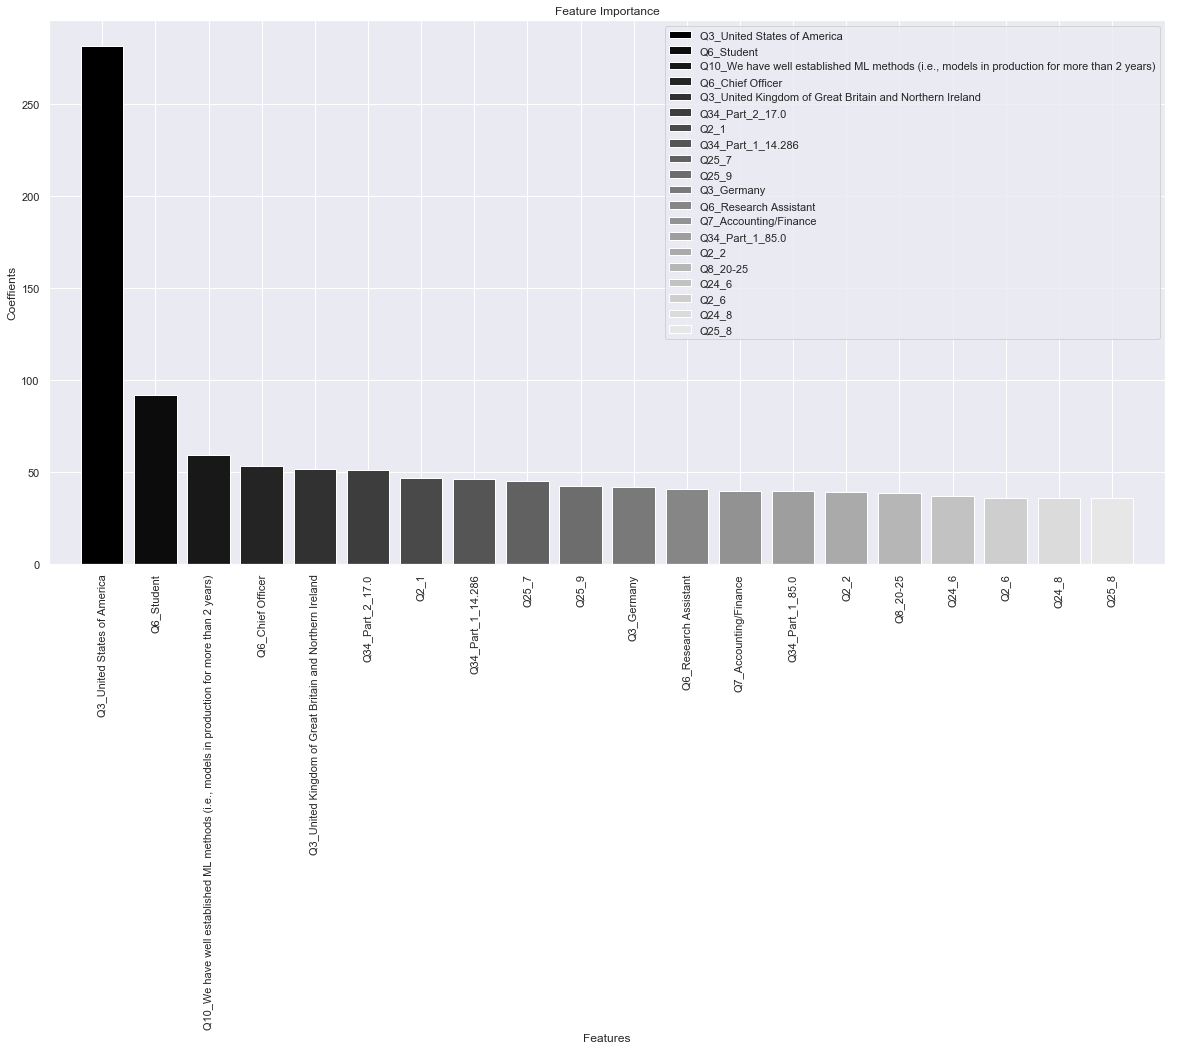

In [86]:
plt.figure(figsize=(20,10))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), 
               abs(laso_importances[indices[:num_to_plot]]),
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_lasso,rotation=90)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(salaries_country.columns[indices[i]]) 
                  for i in range(num_to_plot)]);
plt.xlabel('Features')
plt.ylabel('Coeffients')

## Distribution fo the importance of features

C:\Users\Ween\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Feature Importance Value Distribution')

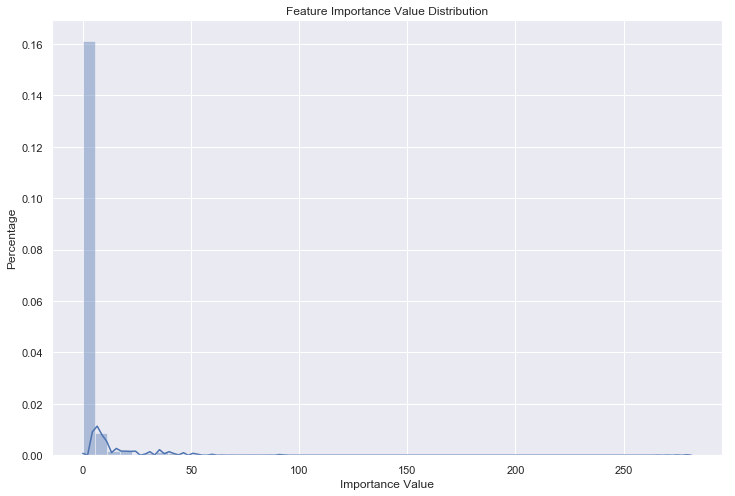

In [87]:
sns.distplot(abs(laso_importances))
plt.xlabel('Importance Value')
plt.ylabel('Percentage')
plt.title('Feature Importance Value Distribution')

## a lot of features have the importance value of 0!

In [88]:
len(laso_importances[abs(laso_importances)>0])
#373 of them have value, but how many features is enough?

373

In [89]:
most_imp_features=indices[:373]
data_sel = salaries_country.values[:,most_imp_features]

In [90]:
#use PCA to see how many features is needed to explain most of the variance
n=[10,20,40,80,100,120,150,200]
for i in n:
    pca=PCA(n_components=i)
    pca.fit(data_sel)
    print('n_components=',i,'\nvariance ratio',pca.explained_variance_ratio_.sum()*100)

n_components= 10 
variance ratio 26.393524386853628
n_components= 20 
variance ratio 41.94964237448232
n_components= 40 
variance ratio 62.270683502021676
n_components= 80 
variance ratio 83.18941852463165
n_components= 100 
variance ratio 88.67656530238234
n_components= 120 
variance ratio 92.73991769194565
n_components= 150 
variance ratio 96.53680140491389
n_components= 200 
variance ratio 99.00649641419706


## top 150 features explain 96% variance, let's just use them

In [91]:
most_imp_features=indices[:150]
X_train_sel = X_train[:,most_imp_features]
X_test_sel = X_test[:,most_imp_features]
data_sel = salaries_country.iloc[:,most_imp_features.tolist()]

In [91]:
data_sel.shape

(7479, 150)

## Feature correlation
### just to check see if there's any high correlated features in the selected one.

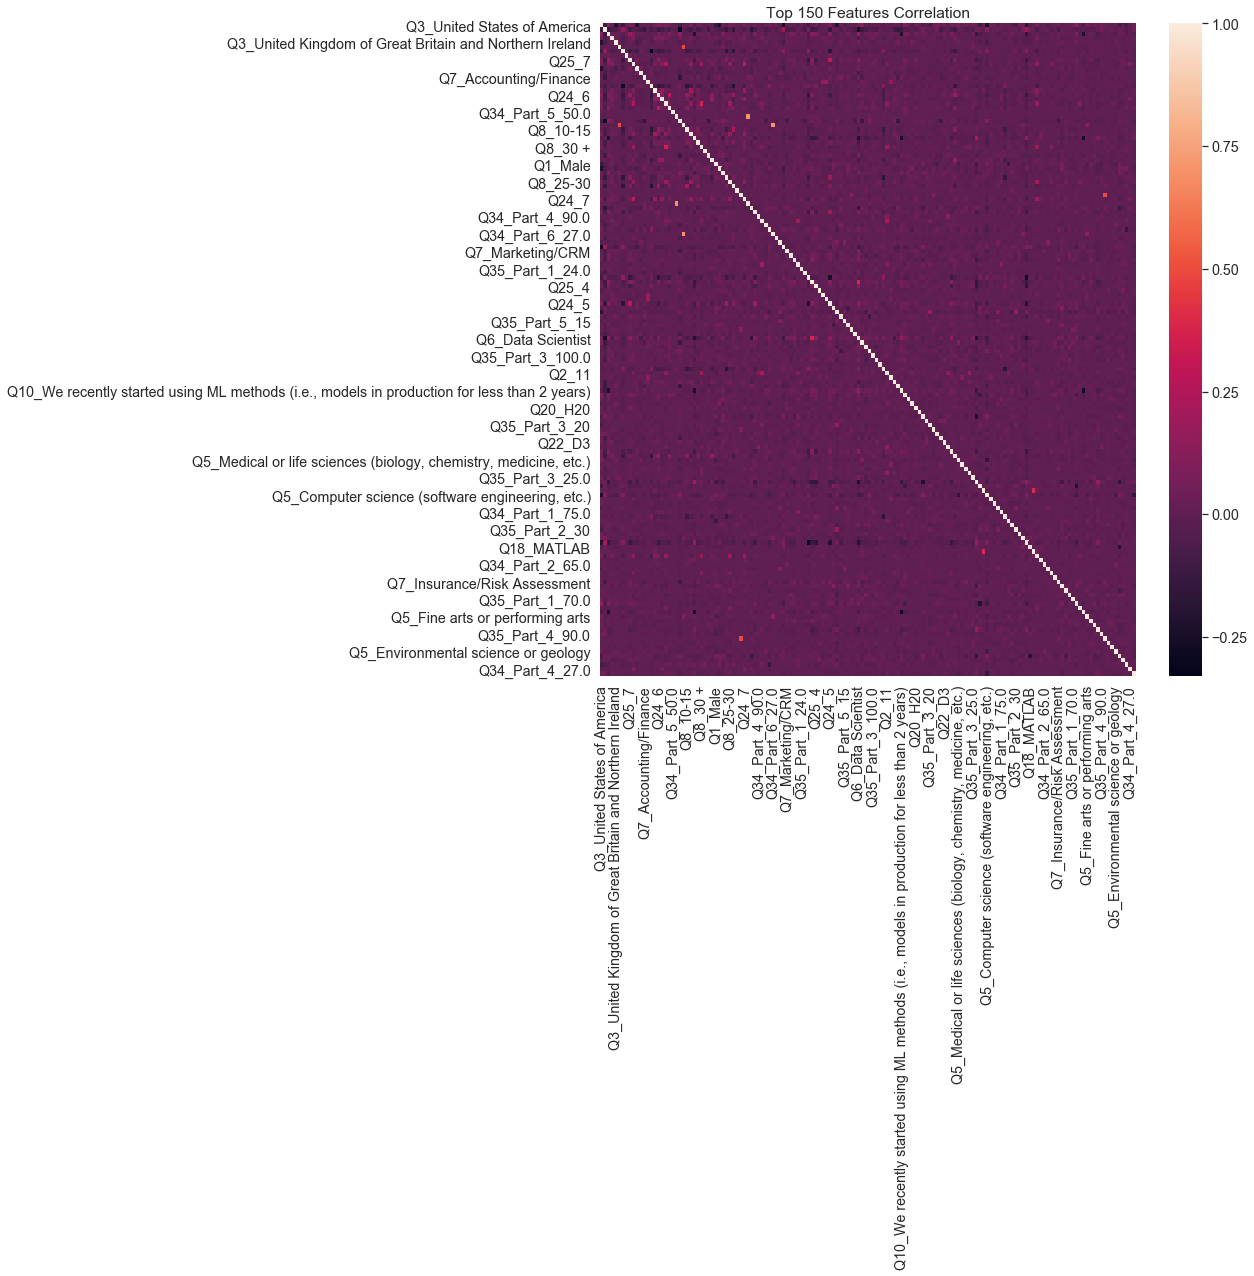

In [149]:
plt.figure(figsize=(12,12))
plt.title('Top 150 Features Correlation')
sns.set(font_scale=1.3) #set font scale so it is more readable
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.3)
sns.heatmap(data_sel.corr())

In [93]:
print('Highly correlated feature:',len(data_sel.corr()[abs(data_sel.corr()>0.7)])-len(most_imp_features))
#great, we don't have any highly correlated features, we are good to go

Highly correlated feature: 0


## Discussion on Feature Importance

### Lasso coefficient is a indicator of feature importance in the model. The bigger the coefficient is, the larger impact the feature has on the model and slight change on an important feature could change the output dramastically. Then rank the features from the most important to least important. Then aplly PCA to see how many features is needed to explain 95% of the variance. As it turns out only 150 features are needed. Just check the feature correlation as feature independance is important as well. Looking at the feature importances plot from Lasso regression, we can see that the country where respond is from takes up a very high position in the top features.  USA dominates the feature importance results along with position title.These makes intuitive sense and we can see that most of the important features are more or less the same from the same question. 
## Important features are:

### 1.Country
### 2.Age
### 3.Use of well established ML models in the company (Q10)
### 4.Title of position (of course)
### 5.How many time devoted to data gathering and cleaning(Q34) (the importance of data engineering!)

# 4.Model implementation

In [94]:
#Split the data
X_train_sel, X_test_sel, y_train , y_test = train_test_split(data_sel.values,y, test_size=0.2, random_state=42)

In [95]:
#scale the data so some model that require data standarization can use
X_train_scal=scaler.fit_transform(X_train_sel)
X_test_scal=scaler.fit_transform(X_test_sel)

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [96]:
#set up cross validation

def run_kfold(model):
    
    X=X_train
    Y=y_train
    
    model.fit(X_train_sel,y_train)
    outcomes=cross_val_score(model,X_train,y_train,cv=10,scoring='r2')
    
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    
    print(outcomes)
    sns.lineplot(y=outcomes*100,x=range(10))
    plt.xlim(0,10)
    plt.ylim(0,100)

    plt.legend(['Average R2 Score'])
    plt.title("Cross validation Score")
    plt.xlabel("Folds")
    plt.ylabel("R2_score")

In [96]:
#define a bias function to calculate the bias
def bias(y_test,y_predict):
    bia = np.mean((y_test-y_predict)**2)
    return bia

In [98]:
model_score=pd.DataFrame()

## Lasso Regression

## with scaling

In [99]:
X_train=X_train_scal
X_test=X_test_scal

Mean r2: 0.4758688563729862
Standard Deviation: 0.06756049934910598
[0.40956273 0.434208   0.58446093 0.45218131 0.53318818 0.57141528
 0.47120333 0.50560638 0.4288027  0.36805972]


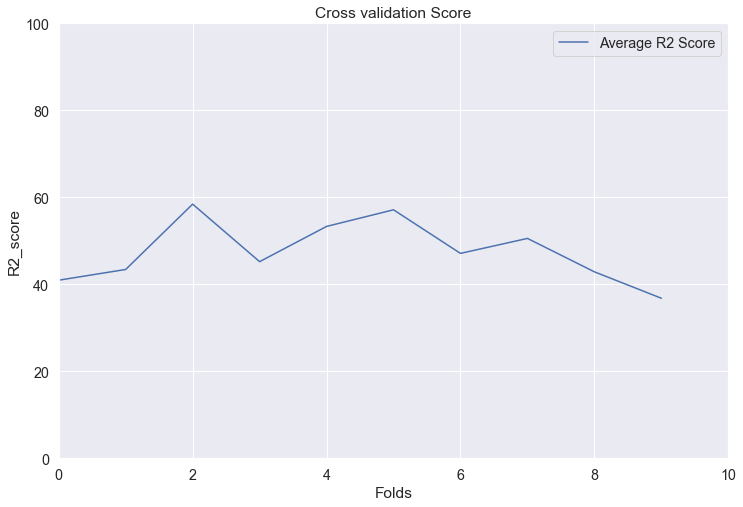

In [100]:
model_ls=Lasso(random_state=42)
run_kfold (model_ls)

In [103]:
lasso_alpha=[0.1,0.5,0.8,.9,0.99,2,3,4,5,6,20,30,40,50,100,200,300]
lasso_bias=[]
lasso_variance=[]
lasso_total=[]
for al in lasso_alpha:
    model_lasso=Lasso(alpha=al, random_state=42)
    model_lasso.fit(X_train,y_train)
    pred=model_lasso.predict(X_train)
    lasso_bias.append(bias(pred,y_train))
    lasso_variance.append(np.var(pred))
    lasso_total.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

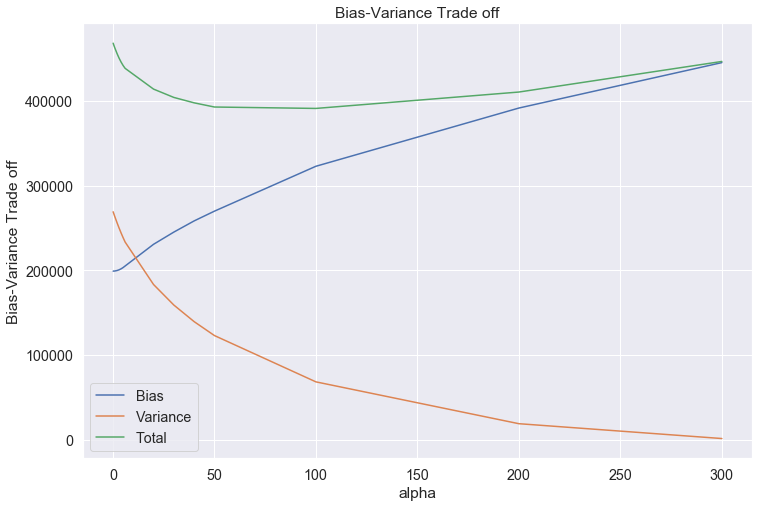

In [104]:
sns.lineplot(x=lasso_alpha,y=lasso_bias)
sns.lineplot(x=lasso_alpha,y=lasso_variance)
sns.lineplot(x=lasso_alpha,y=lasso_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("alpha")
plt.ylabel("Bias-Variance Trade off")

In [105]:
lasso_total.index(min(lasso_total))

14

In [106]:
lasso_alpha[lasso_total.index(min(lasso_total))]

100

## Discussion On Lasso Regression

#### Lasso Regression regularize the linear regression by imposing a penalty on the size of coefficients. Thus the coefficients are shrunk toward zero and toward each other. But when this happens and if the independent variables does not have the same scale, the shrinking is not fair. Two independent variables with different scales will have different contributions to the penalized terms, because the penalized term is a sum of squares of all the coefficients. To avoid such kind of problems, scaling is needed

#### LASSO (Least Absolute Shrinkage Selector Operator) is a regluarlised linear regression and . It fits a linear regressor which as a penalty term that prevents the Beta coefficients from blowing up . Since Lasso uses L1 distance as the measure of estimator for Beta values across the features, it does a good job in pruning out irrelevant features.

#### Fast implementation along with the ability to prune out features was the main pro of this algorithim and it was one of the main criterion for choosing this model. On the other hand this model is not much of use in non linear data unless we insert engineered polynomial features.

#### When applying cross validation, the model accuracy fluctuates across the folds quite a bit. One reason for the variance is due to the data which has very high variability 

# ————————————
## Ridge Regressor

## with scaling

In [107]:
X_train=X_train_scal
X_test=X_test_scal

Mean r2: 0.4745692546935194
Standard Deviation: 0.06591111534455325
[0.40780037 0.43792145 0.58748227 0.45054531 0.52569745 0.56703399
 0.46678307 0.4998189  0.43061168 0.37199806]


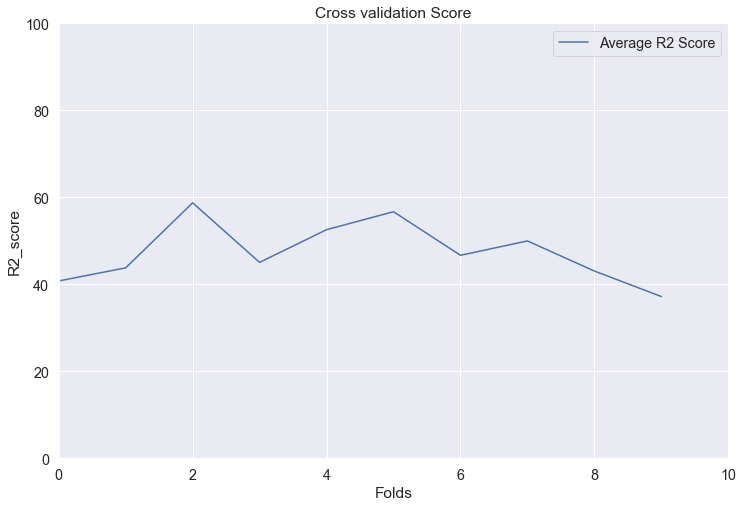

In [108]:
model_ridge=Ridge(random_state=42)
run_kfold (model_ridge)

In [109]:
ridge_alpha=[50,100,300,500,800,1000,2000,4000,6000,8000,10000,30000,60000,100000]
ridge_bias=[]
ridge_variance=[]
ridge_total=[]
for al in ridge_alpha:
    model_ridge=Ridge(alpha=al, random_state=42)
    model_ridge.fit(X_train,y_train)
    pred=model_ridge.predict(X_train)
    ridge_bias.append(bias(pred,y_train))
    ridge_variance.append(np.var(pred))
    ridge_total.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

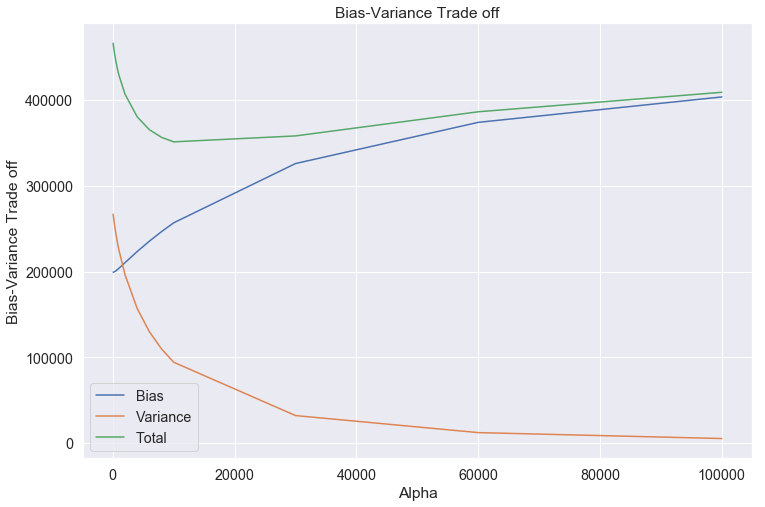

In [110]:
sns.lineplot(x=ridge_alpha,y=ridge_bias)
sns.lineplot(x=ridge_alpha,y=ridge_variance)
sns.lineplot(x=ridge_alpha,y=ridge_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Alpha")
plt.ylabel("Bias-Variance Trade off")

In [111]:
ridge_total.index(min(ridge_total))

10

In [112]:
ridge_alpha[ridge_total.index(min(ridge_total))]

10000

## DIscussion on Ridge Regression

#### Just like Lasso Regression, Ridge regression regularize the linear regression by imposing a penalty on the size of coefficients. Thus the coefficients are shrunk toward zero and toward each other. But when this happens and if the independent variables does not have the same scale, the shrinking is not fair. Two independent variables with different scales will have different contributions to the penalized terms, because the penalized term is a sum of squares of all the coefficients. To avoid such kind of problems, scaling is needed

#### Similar to Lasso Regression, It fits a linear regressor which as a penalty term that prevents the Beta coefficients from blowing up . Here the algorithm uses L2 distance as the measure of estimator for Beta values across the features. Howver, it will not completely eliminate the feature like Lasso since the distance measure boundary is circular in nature .

#### Fast implementation along with the ability to keep beta values in check features was the main pro of this algorithim and it was one of the main criterion for choosing this model. simlar to Lasso this model is not much of use in non linear data unless we insert engineered polynomial features.

#### When applying cross validation, the model accuracy fluctuates across the folds quite a bit. One reason for the variance is due to the data which has very high variability. 

# ————————————
## Random forest
## no scaling needed, 
### Random Forest is a tree based algorithm, hence no scaling is needed.

In [113]:
X_train=X_train_sel
X_test=X_test_sel

Mean r2: 0.4873135306390937
Standard Deviation: 0.07528814156023295
[0.45559712 0.46382884 0.55156205 0.43452381 0.52193752 0.55821651
 0.57790535 0.55288727 0.43184987 0.32482695]


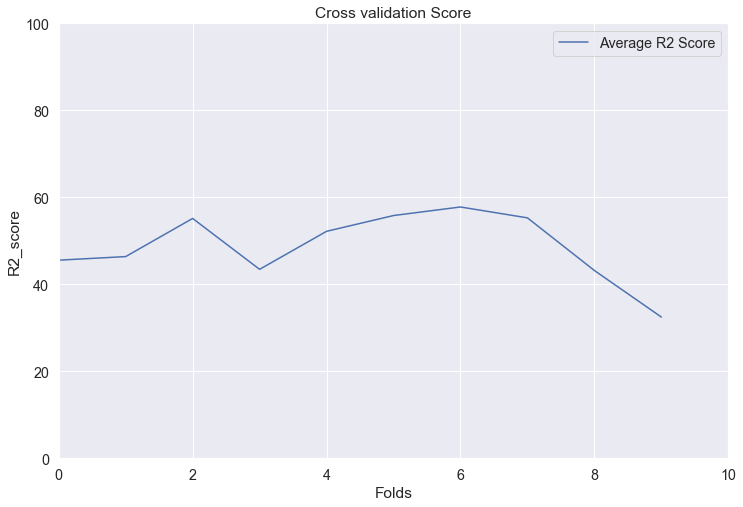

In [114]:
model_rf=RandomForestRegressor(criterion='mse', max_depth=10,n_estimators=100, random_state=42) 
#set n_estimators to default value and  max_depth to 10 to control run time
run_kfold (model_rf)

In [115]:
rf_estimators=[1, 2, 4, 8, 16, 32, 48, 64, 80, 96, 100, 150]
rf_bias_n=[]
rf_variance_n=[]
rf_total_n=[]
for estimator in rf_estimators:
    model_rf=RandomForestRegressor(criterion='mse', max_depth=10,n_estimators=estimator, random_state=42)
    model_rf.fit(X_train,y_train)
    pred=model_rf.predict(X_train)
    rf_bias_n.append(bias(pred,y_train))
    rf_variance_n.append(np.var(pred))
    rf_total_n.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

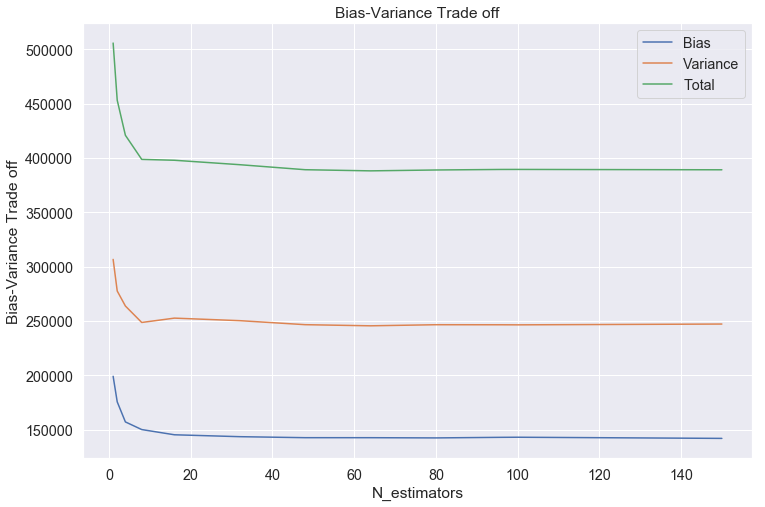

In [116]:
sns.lineplot(x=rf_estimators,y=rf_bias_n)
sns.lineplot(x=rf_estimators,y=rf_variance_n)
sns.lineplot(x=rf_estimators,y=rf_total_n)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("N_estimators")
plt.ylabel("Bias-Variance Trade off")

In [117]:
rf_total_n.index(min(rf_total_n)) #minimum total error index

7

In [118]:
rf_estimators[rf_total_n.index(min(rf_total_n))] #the value that results in minimum total error

64

In [119]:
rf_max_depths = np.linspace(1, 32, 32, endpoint=True)
rf_bias_d=[]
rf_variance_d=[]
rf_total_d=[]
for depth in rf_max_depths:
    model_rf=RandomForestRegressor(criterion='mse', max_depth=depth,n_estimators=64, random_state=42)
    model_rf.fit(X_train,y_train)
    pred=model_rf.predict(X_train)
    rf_bias_d.append(bias(pred,y_train))
    rf_variance_d.append(np.var(pred))
    rf_total_d.append(bias(pred,y_train)+np.var(pred))

Text(0, 0.5, 'Bias-Variance Trade off')

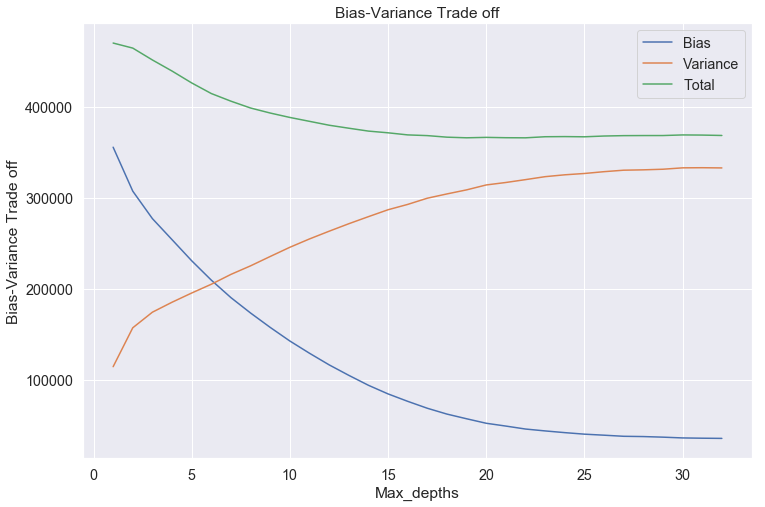

In [120]:
sns.lineplot(x=rf_max_depths,y=rf_bias_d)
sns.lineplot(x=rf_max_depths,y=rf_variance_d)
sns.lineplot(x=rf_max_depths,y=rf_total_d)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Max_depths")
plt.ylabel("Bias-Variance Trade off")

In [121]:
rf_total_d.index(min(rf_total_d)) #minimum total error index

21

In [122]:
rf_max_depths[rf_total_d.index(min(rf_total_d))] #the value that results in minimum total error

22.0

## Discussion on Random Forest

#### Random Forest builds multiple trees by only considering a random sample of features from the full set at every split and at every split only m inputs are available to choose. A Random Forest regressor produce the result by taking the means of each tree's result, so the variance is reduced with slightly increasing of bias.

#### The ability of reducing variance is one of the main pro of this algorithim and it was one of the main criterion for choosing this model. But this model brings slightly increasement of bias and the computational power it requires, still relatively small but much larger than previous two methods, are the cons of the model.

#### When applying cross validation, the model accuracy fluctuates across the folds quite a bit. One reason for this variance is due to the data which has very high variability.

# ————————
## Ada Boosting
#### Boosting, no scaling needed

In [123]:
X_train=X_train_sel
X_test=X_test_sel

Mean r2: 0.3410189279222539
Standard Deviation: 0.05051736466450033
[0.34498919 0.30852041 0.34654059 0.29638443 0.34830493 0.42248143
 0.38247768 0.40013572 0.31966907 0.24068583]


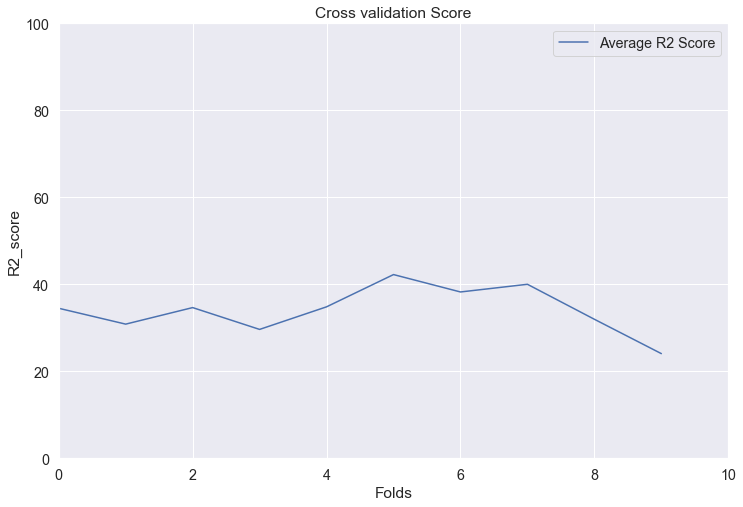

In [124]:
model_ada=AdaBoostRegressor(n_estimators=6,  learning_rate=1.0, random_state=42) 
#set n_estimators and learning_rate to default value
run_kfold (model_ada)

In [125]:
ada_estimators=[1,2,4,6,8,10,12,14,16,18,20,32,64]
ada_bias_n=[]
ada_variance_n=[]
ada_total_n=[]
for estimator in ada_estimators:
    model_ada=AdaBoostRegressor(n_estimators=estimator,learning_rate=1,random_state=42)
    model_ada.fit(X_train,y_train)
    pred=model_ada.predict(X_train)
    ada_bias_n.append(bias(pred,y_train))
    ada_variance_n.append(np.var(pred))
    ada_total_n.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

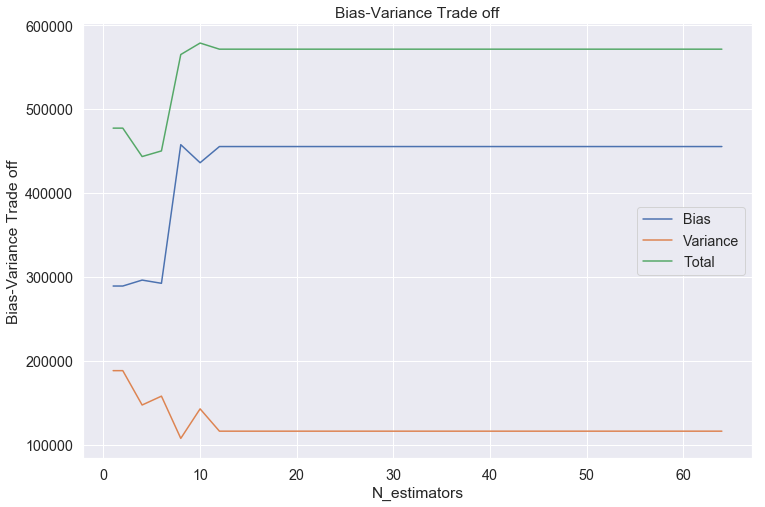

In [126]:
sns.lineplot(x=ada_estimators,y=ada_bias_n)
sns.lineplot(x=ada_estimators,y=ada_variance_n)
sns.lineplot(x=ada_estimators,y=ada_total_n)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("N_estimators")
plt.ylabel("Bias-Variance Trade off")

In [127]:
ada_total_n.index(min(ada_total_n)) #minimum total error index

2

In [128]:
ada_estimators[ada_total_n.index(min(ada_total_n))] #the value that results in minimum total error

4

In [129]:
ada_learning_rate=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.8,1,1.2,1.4]
ada_bias_r=[]
ada_variance_r=[]
ada_total_r=[]
for rate in ada_learning_rate:
    model_ada=AdaBoostRegressor(n_estimators=4,learning_rate=rate,random_state=42)
    model_ada.fit(X_train,y_train)
    pred=model_ada.predict(X_train)
    ada_bias_r.append(bias(pred,y_train))
    ada_variance_r.append(np.var(pred))
    ada_total_r.append(bias(pred,y_train)+np.var(pred))


Text(0, 0.5, 'Bias-Variance Trade off')

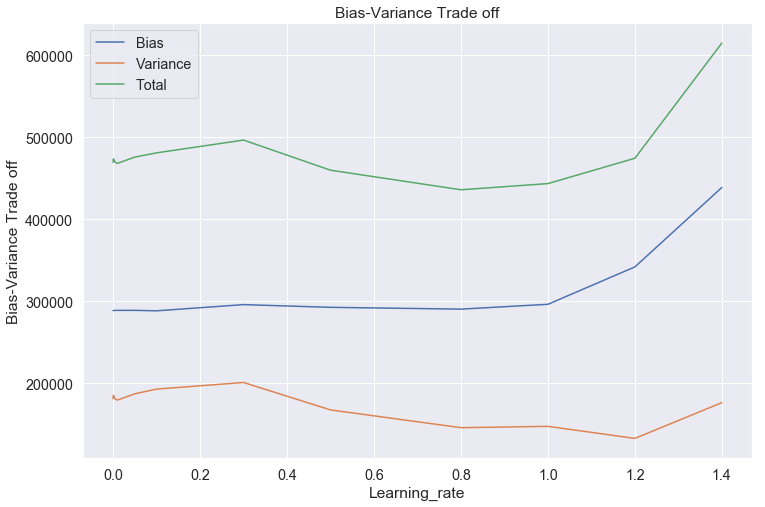

In [130]:
sns.lineplot(x=ada_learning_rate,y=ada_bias_r)
sns.lineplot(x=ada_learning_rate,y=ada_variance_r)
sns.lineplot(x=ada_learning_rate,y=ada_total_r)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Learning_rate")
plt.ylabel("Bias-Variance Trade off")

In [131]:
ada_total_r.index(min(ada_total_r)) #minimum total error index

9

In [132]:
ada_learning_rate[ada_total_r.index(min(ada_total_r))] #the value that results in minimum total error

0.8

## Discussion On Ada Boosting Regression

#### AdaBoost, short for “Adaptive Boosting” aims to convert a set of weak classifiers into a strong one. It is a sequential ensemble that the output of weak learners is combined into a weighted sum that represents the final output of the boosted regressor. . 

#### Each weak learner in AdaBoost can be tweaked in favor of those instance that was mislabled by previous learner, so it is less likely to be overfiting and it was one of the main criterion for choosing this model. But this model is sensitive to noisy data and outliers, which is the con of the model.


### When applying cross validation, the model accuracy is lower than the other model and it fluctuates across the folds quite a bit. One reason for this variance is due to the data which has very high variability and noisy.



## The best model
### Bias-Variance Tradeoff

#### High bias can cause an algorithm to underfit the features and miss the relevant relations between features and target outputs. High variance is error from sensitivity to outliers or niose in the training set and it will lead to overfitting. So when choosing models, we need to be very calful about the balance between bias and variance, and of course we want to minimize the total error. At the minimum total error point, Lasso, Ridge and AdaBoost regression have lower variance but their bias are relatively high which could leads to underfitting while Random Forest Regression has higher variance and lower bias which could have the potential of overfitting, but due to the complexity of the model we are trying to build, this situation is most likely not true. So it only leads to higher acuracy.

#### From what was discussed and base on the result of Bias- Variance trade-off and Cross Validation results, the Random Forest Regression seems to be the best model in this case, but let's give them each a fair chance that we tune each model to perform as its best and then compare.

# 5.Model tuning
## hyperparameter tuning
## Ridge Regression

In [133]:
# %%time

# ridge_params={'alpha':[50,100,300,500,800,1000,2000,4000,6000,8000,10000,30000,60000,100000]} #set parameters

# ridge_grid=GridSearchCV(model_ridge, param_grid=ridge_params,cv=10, n_jobs=-1, verbose=1) #Grid Search

# ridge_grid.fit(X_train_scal,y_train)

# print(ridge_grid.best_estimator_) #print out best estimator

# Fitting 10 folds for each of 14 candidates, totalling 140 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
# Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
#    normalize=False, random_state=42, solver='auto', tol=0.001)
# Wall time: 7.04 s
# [Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.9s finished

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s


Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)
Wall time: 7.04 s


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.9s finished


In [134]:
ridge_pred=ridge_grid.predict(X_train_scal) #make prediction using best estimator
ridge_rmse=sqrt(mean_squared_error(y_train, ridge_pred)) #calculate the root mean sequre error
model_score['Ridge Regression']=[ridge_grid.best_score_,ridge_rmse]

In [135]:
model_score.index=['R2','RMSE']

## Lasso Regression

In [136]:
# %%time

# lasso_params={'alpha':[0.1,0.5,0.8,.9,0.99,2,3,4,5,6,20,30,40,50,100,200,300]}

# lasso_grid=GridSearchCV(model_ls, param_grid=lasso_params,cv=10, n_jobs=-1, verbose=1)

# lasso_grid.fit(X_train_scal,y_train)

# print(lasso_grid.best_estimator_)

# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# Fitting 10 folds for each of 17 candidates, totalling 170 fits
# [Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
# Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000,
#    normalize=False, positive=False, precompute=False, random_state=42,
#    selection='cyclic', tol=0.0001, warm_start=False)
# Wall time: 4.85 s
# [Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    4.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s


Lasso(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Wall time: 4.85 s


[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    4.7s finished


In [137]:
lasso_pred=lasso_grid.predict(X_train_scal) #make prediction using best estimator
lasso_rmse=sqrt(mean_squared_error(y_train, lasso_pred)) #calculate the root mean sequre error
model_score['Lasso Regression']=[lasso_grid.best_score_,lasso_rmse]

## Random Forest

In [138]:
# %%time

# rf_params={'n_estimators':[1, 2, 4, 8, 16, 32, 48, 64, 100],
#           'max_depth':np.linspace(1, 32, 16, endpoint=True)}

# rf_grid=GridSearchCV(model_rf, param_grid=rf_params,cv=10, n_jobs=-1, verbose=1)

# rf_grid.fit(X_train_sel,y_train)

# print(rf_grid.best_estimator_)

# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# Fitting 10 folds for each of 144 candidates, totalling 1440 fits
# [Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   12.5s
# [Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  1.3min
# [Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  4.2min
# [Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 10.5min
# [Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed: 20.5min
# [Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 24.6min finished
# RandomForestRegressor(bootstrap=True, criterion='mse',
#            max_depth=17.533333333333335, max_features='auto',
#            max_leaf_nodes=None, min_impurity_decrease=0.0,
#            min_impurity_split=None, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=100, n_jobs=None, oob_score=False, random_state=42,
#            verbose=0, warm_start=False)
# Wall time: 24min 42s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 24.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse',
           max_depth=17.533333333333335, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
Wall time: 24min 42s


In [139]:
rf_pred=rf_grid.predict(X_train_sel) #make prediction using best estimator
rf_rmse=sqrt(mean_squared_error(y_train, rf_pred)) #calculate the root mean sequre error
model_score['Random Forest Regression']=[rf_grid.best_score_,rf_rmse]

## Ada Boost Regression

In [140]:
# %%time

# ada_params={'n_estimators':[1,2,4,8,12,16,20,32],
#           'learning_rate':[0.001,0.01,0.1,0.3,0.5,0.8,1]}

# ada_grid=GridSearchCV(model_ada, param_grid=ada_params,cv=10, n_jobs=-1, verbose=1)

# ada_grid.fit(X_train_sel,y_train)

# print(ada_grid.best_estimator_)

# Fitting 10 folds for each of 56 candidates, totalling 560 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   12.8s
# [Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   49.4s
# [Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:  1.9min
# [Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  2.2min finished
# AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='linear',
#          n_estimators=12, random_state=42)
# Wall time: 2min 11s

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  2.2min finished


AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='linear',
         n_estimators=12, random_state=42)
Wall time: 2min 11s


In [141]:
ada_pred=ada_grid.predict(X_train_sel) #make prediction using best estimator
ada_rmse=sqrt(mean_squared_error(y_train, ada_pred)) #calculate the root mean sequre error
model_score['Ada Boost Regression']=[ada_grid.best_score_,ada_rmse] 

# Let's see how they perform

In [142]:
model_score
#Looks like Random Forest perform the best!


,Ridge Regression,Lasso Regression,Random Forest Regression,Ada Boost Regression
R2,0.490263,0.479087,0.496417,0.378912
RMSE,451.442589,450.979869,262.608038,539.544114


Text(0, 0.5, 'Models')

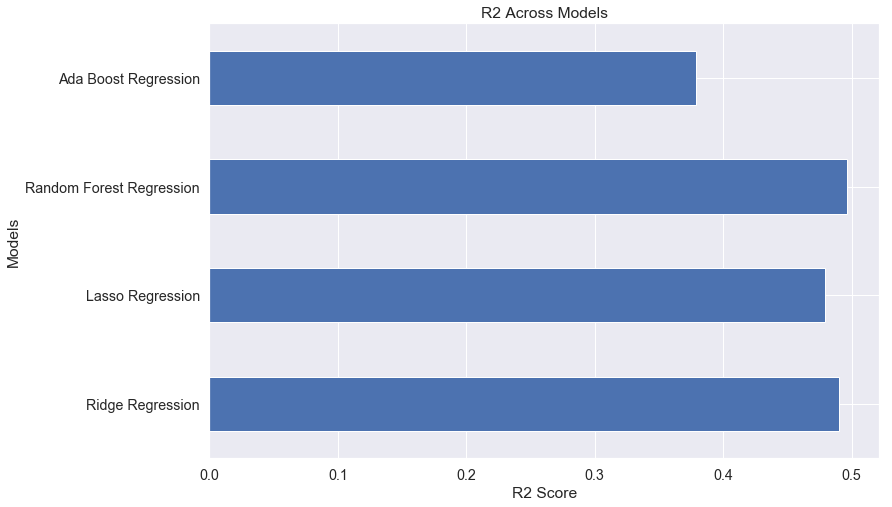

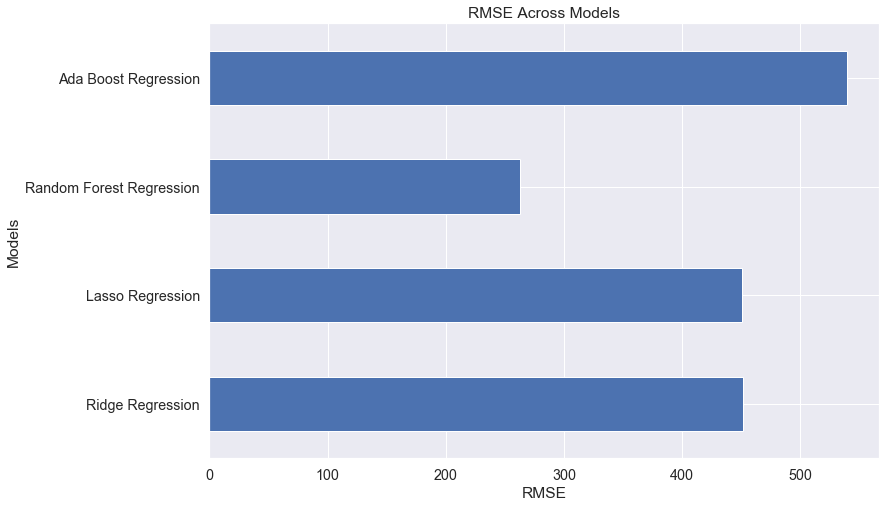

In [143]:
#Plot the result
plt.figure(1)
model_score.loc['R2',:].plot(kind='barh')
plt.title("R2 Across Models")
plt.xlabel("R2 Score")
plt.ylabel("Models")

plt.figure(2)
model_score.loc['RMSE',:].plot(kind='barh')
plt.title("RMSE Across Models")
plt.xlabel("RMSE")
plt.ylabel("Models")

# Choosing optimal Model
### I chose the Random Forest Regressor model as it had the best R2 score and much smaller Root Mean Sequre Error as per the graph shown above.
### R2 score was chosen is to compare the model is that R2 represents the fraction by which the variance of the errors is less than the variance of the dependent variable. So the higher R2 is the better a model performs. While the RMSE is the root of the mean squared error, it represents, in average, how far our prediction is away from the truth.

In [144]:
model=RandomForestRegressor(criterion='mse',max_depth=17.533333333333335,n_estimators=100,random_state=42)
#Build the optimal model

In [145]:
model.fit(X_train_sel,y_train)
prediction=model.predict(X_test_sel) #Test on the test set! exciting!

In [146]:
r2_score(y_test,prediction)
#better score than the train set, not bad for a dataset the model has never seen before.

0.5869979249228452

In [147]:
sqrt(mean_squared_error(y_test, prediction))
# slightly larger RMSE

392.0054056922425

In [148]:
model_score['Random Forest Regression'] #recap on the training set

R2        0.496417
RMSE    262.608038
Name: Random Forest Regression, dtype: float64

## Discussion on the test result

#### The test set was kept out of the model on purpose to validate the model and ensure that a high score of on the training set is not by overfitting the model.

#### The R2 score of test set is 0.587 and training set scores 0.496, which means the model actually perform better in test set and it might be because the model of training set is not strong enough that it not only did not overfit, it can go stronger with the fitting in training. 

#### The RMSE of test set is 392 which is much larger than the 262 of the test set. This could be because of the relatively smaller size of the test data and very few outliers led to this, as the R2 score is much higher in the test set.

#### The overall fit of the model perform ok given the inherent issues with the dataset, so the model does not overfitting. However, I feel the model might underfit slightly as the RMSE of test set is much higher while R2 score is high as they were discussed above.

#### The model could be improved much more using methods below:

#### 1.Spend more time on cleaning data of the multi-choice questions and might be able to eliminate more dirty data that does not make sense
#### 2.Better feature engineering - looking deeper into the relations between features and could use polynomial features
#### 3.Conduct Gridsearch on more parameters for the regressors
#### 4.Try other models like Neural network etc. 
### we will try number 4 below


# Bonus Neural Network

In [92]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,8,4), random_state=1, max_iter=1000)
nn.fit(X_train_sel, y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 8, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [94]:
pred_train=nn.predict(X_train_sel)
pred_test=nn.predict(X_test_sel)
print('r2 score of train set is:',r2_score(y_train,pred_train))
print('r2 score of test set is:',r2_score(y_test,pred_test))
print('RMSE of train set is:',sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE of test set is:',sqrt(mean_squared_error(y_test, pred_test)))

r2 score of train set is: 0.7884367448434135
r2 score of test set is: -3.403419218381039
RMSE of train set is: 315.063413144436
RMSE of test set is: 1280.0029065559365


# Baseline is set looks like it overfit

## Simply try the model with one layer less

In [107]:
nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,8), random_state=1, max_iter=1000)
nn.fit(X_train_sel, y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 8), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [108]:
pred_train=nn.predict(X_train_sel)
pred_test=nn.predict(X_test_sel)
print('r2 score of train set is:',r2_score(y_train,pred_train))
print('r2 score of test set is:',r2_score(y_test,pred_test))
print('RMSE of train set is:',sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE of test set is:',sqrt(mean_squared_error(y_test, pred_test)))

r2 score of train set is: 0.85615606819931
r2 score of test set is: -2.0611642951690783
RMSE of train set is: 259.79071545478274
RMSE of test set is: 1067.2330319405394


## still overfitting but better, let's try one less layer

In [109]:
nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter=1000)
nn.fit(X_train_sel, y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [110]:
pred_train=nn.predict(X_train_sel)
pred_test=nn.predict(X_test_sel)
print('r2 score of train set is:',r2_score(y_train,pred_train))
print('r2 score of test set is:',r2_score(y_test,pred_test))
print('RMSE of train set is:',sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE of test set is:',sqrt(mean_squared_error(y_test, pred_test)))

r2 score of train set is: 0.6376682149345914
r2 score of test set is: 0.5326953893177301
RMSE of train set is: 412.31683737984923
RMSE of test set is: 416.9807172833164


## see what bias-variance tradeoff can tell us

Text(0, 0.5, 'Bias-Variance Trade off')

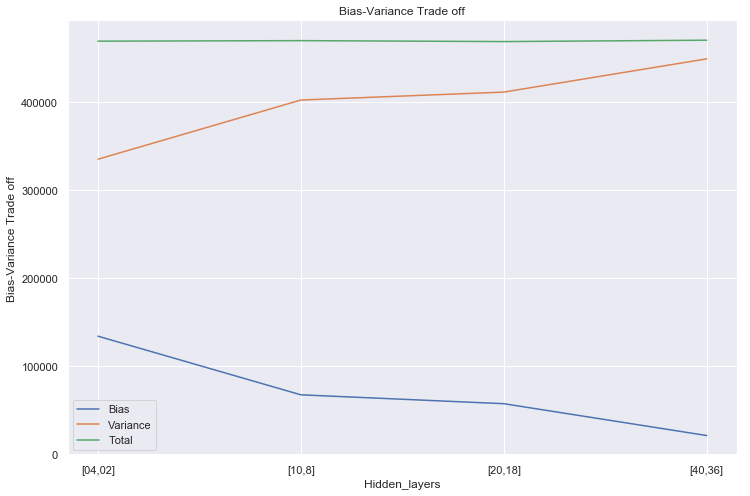

In [112]:
#first try 2 layers
hidden_layer=[[4,2],[10,8],[20,18],[40,36]] 
nn_bias=[]
nn_variance=[]
nn_total=[]
for layer in hidden_layer:
    nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(layer), random_state=1, max_iter=1000)
    nn.fit(X_train_sel, y_train)
    pred=nn.predict(X_train_sel)
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


layer=('[04,02]','[10,8]','[20,18]','[40,36]')
sns.lineplot(x=layer,y=nn_bias)
sns.lineplot(x=layer,y=nn_variance)
sns.lineplot(x=layer,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Hidden_layers")
plt.ylabel("Bias-Variance Trade off")

## we can see a clear trend that bias and variance divergent over the increasing in number of nodes in each layer. Bias goes close to zero while variance increase a lot, which is a clear sign of overfitting. Another observation is that the total error keep at the same value

Text(0, 0.5, 'Bias-Variance Trade off')

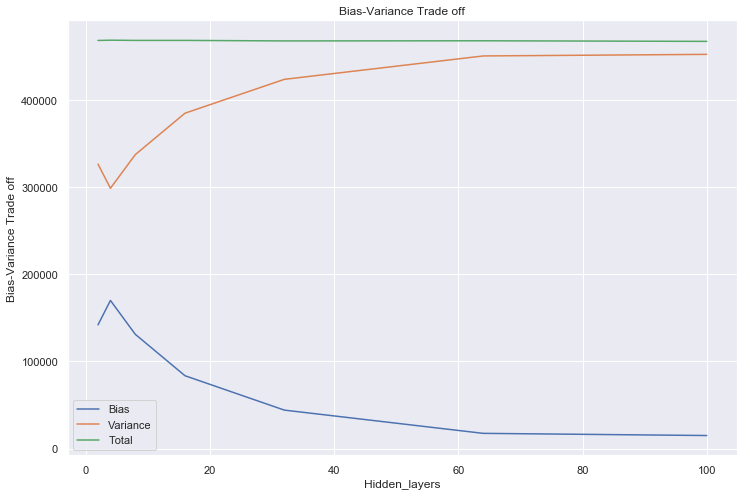

In [113]:
#now try 1 layers
hidden_layer=[2,4,8,16,32,64,100] 
nn_bias=[]
nn_variance=[]
nn_total=[]
for layer in hidden_layer:
    nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(layer,), random_state=1, max_iter=1000)
    nn.fit(X_train_sel, y_train)
    pred=nn.predict(X_train_sel)
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))

sns.lineplot(x=hidden_layer,y=nn_bias)
sns.lineplot(x=hidden_layer,y=nn_variance)
sns.lineplot(x=hidden_layer,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Hidden_layers")
plt.ylabel("Bias-Variance Trade off")

## with simply one layer with 4 nodes per layer bias and variance are closest to each other but no crossing in their path. Again, the total error stays the same
## now try the max_iterations

Text(0, 0.5, 'Bias-Variance Trade off')

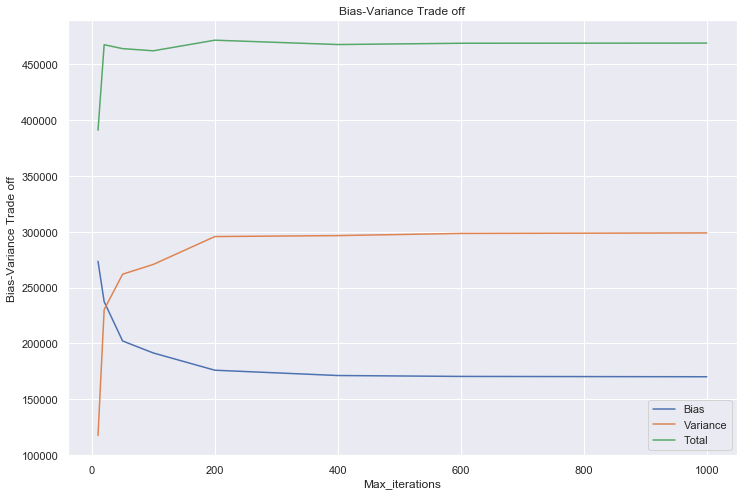

In [115]:
max_iterations=[10,20,50,100,200,400,600,1000] 
nn_bias=[]
nn_variance=[]
nn_total=[]
for iterations in max_iterations:
    #set the layer to single layer and 4 nodes
    nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4,), random_state=1, max_iter=iterations) 
    nn.fit(X_train_sel, y_train)
    pred=nn.predict(X_train_sel)
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


sns.lineplot(x=max_iterations,y=nn_bias)
sns.lineplot(x=max_iterations,y=nn_variance)
sns.lineplot(x=max_iterations,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Max_iterations")
plt.ylabel("Bias-Variance Trade off")

## finally the paths of bias and variance crossed! at 20 iteration, wow a small number
## now the learning rate

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'Bias-Variance Trade off')

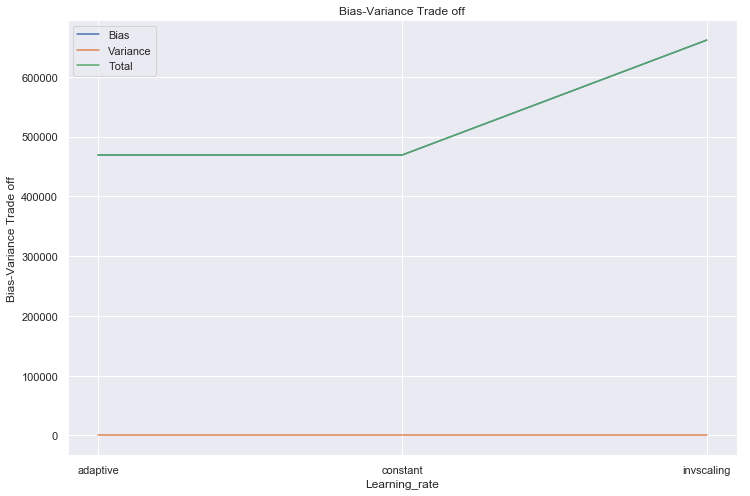

In [121]:
learning_rate=['adaptive', 'constant', 'invscaling'] 
nn_bias=[]
nn_variance=[]
nn_total=[]
for rate in learning_rate:
    #set the layer to single layer and 4 nodes and max_iteration to 20
    #set the learning_rate but leave learning_rate_init as default
    #change the solver to 'sgd' as the parameter is only used in 'sgd'
    nn = MLPRegressor(solver='sgd', alpha=1e-5, hidden_layer_sizes=(4,), random_state=1, max_iter=20, learning_rate=rate) 
    nn.fit(X_train_sel, y_train)
    pred=nn.predict(X_train_sel)
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


sns.lineplot(x=learning_rate,y=nn_bias)
sns.lineplot(x=learning_rate,y=nn_variance)
sns.lineplot(x=learning_rate,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("Learning_rate")
plt.ylabel("Bias-Variance Trade off")

## invscaling has the same variance but the bias went up and hence the total error is up. Interestingly, variance is 0, sign of underfitting
## now momentum

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Text(0, 0.5, 'Bias-Variance Trade off')

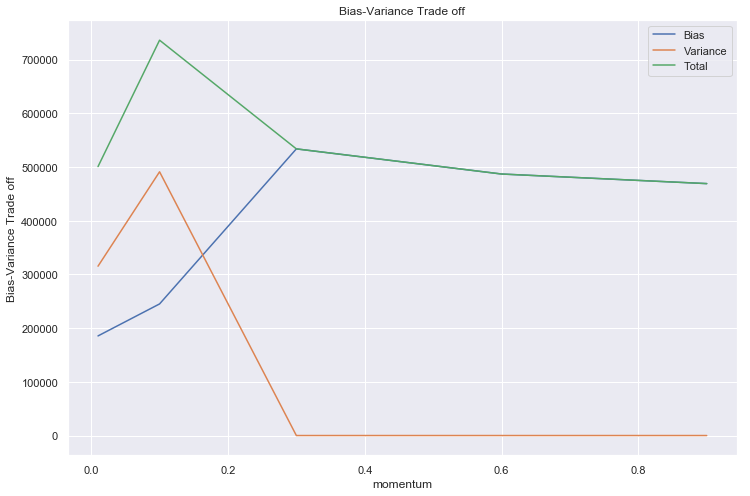

In [120]:
momentum=[0.01,0.1,0.3,0.6,0.9] 
nn_bias=[]
nn_variance=[]
nn_total=[]
for m in momentum:
    #set the layer to single layer and 4 nodes and max_iter=20
    #change solver to 'sgd' as the the momentum is only used in 'sgd'
    nn = MLPRegressor(solver='sgd', alpha=1e-5, hidden_layer_sizes=(4,), random_state=1, max_iter=20, momentum=m) 
    nn.fit(X_train_sel, y_train)
    pred=nn.predict(X_train_sel)
    nn_bias.append(bias(pred,y_train))
    nn_variance.append(np.var(pred))
    nn_total.append(bias(pred,y_train)+np.var(pred))


sns.lineplot(x=momentum,y=nn_bias)
sns.lineplot(x=momentum,y=nn_variance)
sns.lineplot(x=momentum,y=nn_total)
plt.legend(['Bias','Variance','Total'])
plt.title("Bias-Variance Trade off")
plt.xlabel("momentum")
plt.ylabel("Bias-Variance Trade off")

## the solver actually perform worse than what we had, the total error is high when bias and variance crossed
## plot the parameters from manually tune model

In [136]:
nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4,), random_state=1, max_iter=20)
nn.fit(X_train_sel, y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [137]:
pred_train=nn.predict(X_train_sel)
pred_test=nn.predict(X_test_sel)
print('r2 score of train set is:',r2_score(y_train,pred_train))
print('r2 score of test set is:',r2_score(y_test,pred_test))
print('RMSE of train set is:',sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE of test set is:',sqrt(mean_squared_error(y_test, pred_test)))

r2 score of train set is: 0.49402038422789607
r2 score of test set is: 0.5614666450136863
RMSE of train set is: 487.24160339278586
RMSE of test set is: 403.9403661651381


## Lower than I expected, let's tune a bit more just for the sake of fun
## From the first try with 1 hidden layer and 10 nodes, combining with discoveries in bias-variance tradeoff, I test a few times with the number, max_iter=50 was chose

In [134]:
nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter=50)
nn.fit(X_train_sel, y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [135]:
pred_train=nn.predict(X_train_sel)
pred_test=nn.predict(X_test_sel)
print('r2 score of train set is:',r2_score(y_train,pred_train))
print('r2 score of test set is:',r2_score(y_test,pred_test))
print('RMSE of train set is:',sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE of test set is:',sqrt(mean_squared_error(y_test, pred_test)))

r2 score of train set is: 0.5880834318062659
r2 score of test set is: 0.6009919388061928
RMSE of train set is: 439.6251034468962
RMSE of test set is: 385.3068890367362


## Time for grid search

In [140]:
# %%time

# nn_params={'max_iter':[10,15,20,25,30,35,50,70],
#            'hidden_layer_sizes':[(4,),(6,),(8,),(10,)]}
# nn_grid=GridSearchCV(nn, param_grid=nn_params, n_jobs=-1, verbose=1)

# nn_grid.fit(X_train_sel,y_train)

# print(nn_grid.best_estimator_)

# Fitting 3 folds for each of 32 candidates, totalling 96 fits
# [Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
# [Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   24.1s finished
# MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
#        beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=(10,), learning_rate='constant',
#        learning_rate_init=0.001, max_iter=35, momentum=0.9,
#        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#        random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
#        validation

C:\Users\Ween\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   24.1s finished


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=35, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Wall time: 24.9 s


In [141]:
pred_train=nn_grid.predict(X_train_sel)
pred_test=nn_grid.predict(X_test_sel)
print('r2 score of train set is:',r2_score(y_train,pred_train))
print('r2 score of test set is:',r2_score(y_test,pred_test))
print('RMSE of train set is:',sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE of test set is:',sqrt(mean_squared_error(y_test, pred_test)))

r2 score of train set is: 0.5797605252832512
r2 score of test set is: 0.6099388403262104
RMSE of train set is: 444.0442755706846
RMSE of test set is: 380.9625568469489


## Let's see the the result of random forest
## r2 score of train set is: 0. 496417
## r2 score of test set is: 0. 586997
## RMSE of train set is: 262.608038
## RMSE of test set is: 392.005405

### Neural network got a higher r2 scores in both train and test set, but the RMSE of the train set in Random Forest has a much lower value, I believe it is thanks to the nature of Random Forest as it reduce variance a lot. But from what we can see now, neural network is better and faster.